# Open Food Facts Notebook
## Table of Contents
1. [Helper Functions](#Helper-Functions) 
2. [Cleaning Data](#cleaning_data)  
    2.1 [Fill in missing Product Name](#product_name)  
    2.2 [Fill in Missing Values for Country](#country)  
    2.3 [Fill in Missing Nutrion Scores](#nutrition-scores)  
    2.4 [Fill in Missing Allergens](#allergens)  
    2.5 [Fill in Missing Traces](#traces)  
    2.6 [Fill/Clean Ingredients](#ingredients)  
    2.7 [Fill/Clean Labels](#labels_column)  
    2.8 [Clean float64 Columns](#float64_col) 
    2.9 [Processing Data](#processing_data)  
3. [Data Visualization & Analysis](#data_analysis)  
    3.1 [Maps](#Maps)  
    3.2 [Correlations Between Neighbouring Countries](#correlation_neighbours)

# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import folium
import json
import re, os
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
import time

#from google.cloud import translate
#import pycountry
#import emoji

#translate_client = translate.Client()

import sys # for printing process
import unidecode # for normalizing text
from pathlib import Path # check files


#from py_translator import Translator
from google.cloud import translate
translator = translate.Client()

Setup path to Google Cloud Translation API credentials JSON

In [11]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.environ['HOME'] + "/keys/ADA-translation-1fb38fd06474.json"
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

/Users/age/keys/ADA-translation-1fb38fd06474.json


Quick test of the API

In [12]:
translator.translate('hola', target_language='en')['translatedText']

'Hello'

We need to create a data folder where the .csv file will be stored and also a maps folder where .html maps will be stored. Throughout the project, the following constants will be needed.

In [2]:
# CONSTANTS

# General parameters
# unknown values to use
UNKNOWN_NR='-1'
UNKNOWN_STR='unknown'
# delay between translation requests
TRANSLATION_DELAY=0.5
# progress in function
PROGRESS=0

# Folders
data_folder = './data/'
maps_folder = './maps/'

# File names
filename = 'en.openfoodfacts.org.products.csv'
countryfile = 'wikipedia-iso-country-codes.csv'
country_json_file = 'world-countries.json'
translationsfile = 'translations.csv'
foodfile = 'food.csv'

In [3]:
# Columns used for analysis from the csv file
using_col = [
    "product_name",
    "generic_name",
    "quantity",
    "brands",
    "brands_tags",
    "categories",
    "categories_tags",
    "categories_en",
    "manufacturing_places",
    "manufacturing_places_tags",
    "labels",
    "labels_tags",
    "labels_en",
    "purchase_places",
    "countries",
    "countries_tags",
    "countries_en",
    "ingredients_text",
    "allergens",
    "allergens_en",
    "traces",
    "traces_tags",
    "traces_en",
    "nutrition_grade_uk",
    "nutrition_grade_fr",
    "main_category",
    "main_category_en",
    "energy_100g",
    "energy-from-fat_100g",
    "fat_100g",
    "saturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "alcohol_100g",
    "calcium_100g",
    "iron_100g",
    "carbon-footprint_100g",
    "nutrition-score-fr_100g",
    "nutrition-score-uk_100g",
    "glycemic-index_100g"
]

In [15]:
# cache translations to save translation requests and $$$
translations_file = Path(data_folder + translationsfile)
translations = {}

if not translations_file.is_file():
    print('Translations file not found')
else:
    print('Translations file found')
    translations = pd.read_csv(data_folder + translationsfile, 
                               sep='\t',
                               low_memory=False).to_dict("records")[0]
    print('{} translations found'.format(len(translations)))

Translations file found
15862 translations found


In [4]:
food_file = Path(data_folder + foodfile)
food_df = pd.DataFrame()

if not food_file.is_file():
    print('Food file not found')
    food_df = pd.read_csv(data_folder + filename, 
                      sep='\t',
                      usecols = using_col,
                      quotechar='"', 
                      low_memory=False)
else:
    print('Food file found')
    food_df = pd.read_csv(data_folder + foodfile, 
                      sep='\t',
                      low_memory=False)
    print('{} Food entries found'.format(len(food_df)))


Food file found
725681 Food entries found


In [32]:
final_df = food_df.copy()

In [17]:
print("The types of the data set are: \n", format(food_df.dtypes))
print ("The total size of the data set is:", format(food_df.shape) )
food_df.head(5)

The types of the data set are: 
 product_name                  object
generic_name                  object
quantity                      object
brands                        object
brands_tags                   object
categories                    object
categories_tags               object
categories_en                 object
manufacturing_places          object
manufacturing_places_tags     object
labels                        object
labels_tags                   object
labels_en                     object
purchase_places               object
countries                     object
countries_tags                object
countries_en                  object
ingredients_text              object
allergens                     object
allergens_en                  object
traces                        object
traces_tags                   object
traces_en                     object
nutrition_grade_uk           float64
nutrition_grade_fr            object
main_category                 object
main_

,product_name,generic_name,quantity,brands,brands_tags,categories,categories_tags,categories_en,manufacturing_places,manufacturing_places_tags,...,proteins_100g,salt_100g,sodium_100g,alcohol_100g,calcium_100g,iron_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g
0,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.8,1.40,0.551181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cacao,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,2.04,0.803150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mendiants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Salade de carottes râpées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9,0.42,0.165354,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper Functions 
[[up](#Table-of-Contents)]

In [18]:
# Gets the first non null value from gibben collumns in priority order
def getValueWithPriorityColumns(input_row, merging_columns):
    for column in merging_columns:
        if pd.notnull(input_row[column]):
            return input_row[column]
    return input_row[merging_columns[0]]

# Merges from a input DF the desired columns into a result column
def mergeColumnsFromDF(input_df, desired_columns, result_column):
    if result_column in input_df.columns:
        return input_df

    input_df[result_column] = input_df.apply(
        lambda x: getValueWithPriorityColumns(x,desired_columns),
        axis = 1
    )
    for column in desired_columns:
        if column in input_df.columns:
            input_df = input_df.drop(column, axis=1)

    return input_df


In [19]:
# Translates a value and saves it to translations cache dict
def translateWithCache(value):
    global translations
    # search translated word in translations map
    if value in translations:
        # print("Cached  {} -> {}".format(value,translations[value]))
        return translations[value]
    else:
        try:
            #print(1)
            time.sleep(TRANSLATION_DELAY) 
            #print(2)
            trns_value = translator.translate(value, target_language='en')
            if not trns_value is None:
                new_translation=trns_value['translatedText'].lower()
                #print("Translating {} -> {}".format(value,new_translation))
                translations[value]=new_translation
                return new_translation
            else:
                print("None {} / {} / {}".format(value,type(value), e))
        except Exception as e:
            #err = e
            print("Exception {} / {} / {}".format(value,type(value), e))
        return value

In [211]:
# Save to file translations dict
def saveTranslations():
    pd.DataFrame.from_dict(translations,orient="index").T.to_csv(data_folder + translationsfile,sep='\t',index=False)

# Save to file a dataframe with gibben name
def saveModuleDF(name,df):
    df.to_csv(data_folder + name + '.csv', sep='\t',index=False)
    print('Saved module: {}'.format(name))

# Save to file food dataframe 
def saveFinalDF(df):
    global final_df 
    final_df = df.copy()
    saveModuleDF('food',df)

# Looks for existing file saved and returns it if found or a food_df copy
def getModuleDF(name):
    file_name=data_folder + name + '.csv'
    file = Path(file_name)

    if not file.is_file():
        print('{} file not found'.format(name))
        return final_df.copy()
    else:
        print('{} file found'.format(name))
        df = pd.read_csv(file_name, 
                          sep='\t',
                          low_memory=False)
        print('{} {} entries found'.format(len(df),name))
        return df

    
    
# Removes special character, numbers, accents, sets to lower case and removes trailing spaces
def normalizeString(string):
    cleaned=''.join([i for i in string if (i.isalnum() & ~i.isdigit()) | i.isspace() ])
    # return unidecode.unidecode(cleaned.lower().strip())
    return cleaned.lower().strip()

# Removes array without duplicate values
def removeDuplcates(array):
    newItems=[]
    for item in array:
        if item and item not in newItems:
            newItems.append(item)
    
    return newItems


In [21]:
# Shows progress during processing
def showProgress(size):
    global PROGRESS 
    PROGRESS += 1
    progress_value = int(10000*PROGRESS/size)/100
    if (progress_value*100)%1==0:
        sys.stdout.write('\r'+'Progress {}%'.format(progress_value))
        sys.stdout.flush()
        
# Show NaN percentage of column values in input df    
def showNanPercentage(df,desired_columns):
    for column in desired_columns:
        print("Percentage of NaN in {} is {:.2f}%".format(column,100*len(df[df[column].isna()])/len(df) ))
        

In [22]:
# formats and translate rows formated as a list of values
def formatAndTranslateRow(row, size, translateNoFormat):
    showProgress(size)
    if type(row) is not list and pd.notnull(row) :
        raw_data = row.lower().split(',')
        data = []
        for value in raw_data:
            # format <langage_code:info>
            if (':') in value:
                info_ = value.split(':')
                if len(info_) == 2:
                    # already in english
                    if info_[0] == 'en':
                        #print("Appending 1 {}".format(info_[1]))
                        data.append(info_[1])
                    # translate to english
                    else:
                        #print("Translating {}".format(info_[1]))
                        data.append(translateWithCache(info_[1]))
                else:
                    data.append(info_)
                    #print("Appending 2 {}".format(info_))
                
            # no format, let's translate it
            else:
                #print("No Cont : {}".format(value))
                if translateNoFormat:
                    data.append(translateWithCache(value))
                else:
                    #print("Appending 3 {}".format(value))
                    data.append(value)
        #print(data)
        return data                       
    else:
        return row
    


# Cleaning Data  <a id="cleaning_data"></a> [[up](#Table-of-Contents)]

In [18]:
# remove rows where the columns we are interested in are all null
food_df = food_df.dropna(subset=using_col, how='all')
saveFoodDF(food_df)

Saved module: food


## Fill in Missing Product Name <a id="product_name"></a> [[up](#Table-of-Contents)]

This section deals with NaN values for `product_name`. If it does not have a `product_name`, the `generic_name` was used. If neither field was filled, then a combination of `brands` and `categories_en`/`main_category` was used.

In [28]:
desired_columns = [
    'product_name',
    'generic_name',
    'main_category',
    'main_category_en',
    'brands',
    'brands_tags',
    'categories',
    'categories_tags',
    'categories_en',
]

result_column='product_name_value'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in product_name is 3.73%
Percentage of NaN in generic_name is 88.88%
Percentage of NaN in main_category is 74.23%
Percentage of NaN in main_category_en is 74.23%
Percentage of NaN in brands is 33.17%
Percentage of NaN in brands_tags is 33.18%
Percentage of NaN in categories is 74.21%
Percentage of NaN in categories_tags is 74.21%
Percentage of NaN in categories_en is 74.22%


In [24]:
df = getModuleDF(result_column)
FOUND_MODULE = result_column in df.columns
print("Found module: {}".format(FOUND_MODULE))

product_name_value file found
693846 product_name_value entries found
Found module: True


In [136]:
def get_name(row):
    showProgress(df.shape[0])
    if pd.isnull(row['product_name']):
        if pd.isnull(row['generic_name']):
            if pd.isnull(row['main_category_en']) & pd.isnull(row['categories_en']) & pd.isnull(row['brands']):
                return
            else:
                category_name = row['main_category_en']
                if pd.isnull(category_name):
                    category_name = row['categories_en']
                return "{} {}".format(row['brands'], category_name)
        else:
            return row['generic_name']
    else:
        return row['product_name']


In [137]:
if not FOUND_MODULE:
    PROGRESS=0
    
    df[result_column] = df.apply(
        lambda x: get_name(x),
        axis = 1
    )
    
    # removing the columns that we no longer need
    df = df.drop(desired_columns, axis=1)
    saveModuleDF(result_column,df)


In [25]:
print("Number of rows w/missing product_name after modifications: {}".format(len(df) - df[result_column].count()))

Number of rows w/missing product_name after modifications: 22458


Save dataframe into food csv

In [31]:
saveFinalDF(df)

Saved module: food


As seen in the results, 22 458 rows still do not have names after our modifications. Our team decided that names were not of particular importance for our analysis, so we decided to leave these no-named items in the dataframe. The name is not important because we mostly want to analyze the ingredients of the items for each country. Thus the `labels`, `allergens`, and the numbers for sugar/sodium/calcium/etc and `countries` are the important columns.

## Fill in Missing Values for Country <a id="country"></a> [[up](#Table-of-Contents)]
This section deals with the missing values for `countries_en`. The `countries_en` column represents the countries where the product is sold. This column is important for our analysis because we want to analyze how viable it is to live in each country based off one's dietary restrictions.

In order to fix these missing values, we decided to first fill the column with values from `purchase_places`, then `manufacturing_places`. We decided to use `purchase_places` because if it was purchased in a certain country, obviously it means the product is sold there as well. As for `manufacturing_places`, we assumed that it is most likely that a product manufactured in a country would be sold there as well.

Furthermore, we looked at the column `origins`, however this column is actually describing where each ingredient came from. This would not be helpful for us because the origin would not tell us about which countries actually sell/consume this specific item.

In [38]:
desired_columns = [
    'countries_en',
    'purchase_places',
    'manufacturing_places',
    'manufacturing_places_tags',
    'countries_tags',
    'countries'
]

result_column='country_name'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in countries_en is 0.07%
Percentage of NaN in purchase_places is 85.51%
Percentage of NaN in manufacturing_places is 90.35%
Percentage of NaN in manufacturing_places_tags is 90.35%
Percentage of NaN in countries_tags is 0.07%
Percentage of NaN in countries is 0.07%


In [39]:
df_1 = getModuleDF(result_column)
FOUND_MODULE = result_column in df.columns
print("Found module: {}".format(FOUND_MODULE))

country_name file not found
Found module: False


In [40]:
print("Number of rows w/missing countries_en: {}".format(len(df_1) - df_1['countries_en'].count()))

Number of rows w/missing countries_en: 459


In [41]:
df_1['countries_en'].count()

693387

In [42]:
def translate_country(row,size):
    showProgress(size)
    if pd.isnull(row['countries_en']):
        alt_country = None
        if pd.notna(row['purchase_places']):
            alt_country = row['purchase_places']
        elif pd.notna(row['manufacturing_places']):
            alt_country = row['manufacturing_places']
            
        # got value from purchase_places or manufacturing_places
        if (not alt_country is None) and pd.notna(alt_country):
            try:
                en_alt_country = translateWithCache(alt_country)
                if not en_alt_country is None:
                    return en_alt_country.text
            except Exception as e:
                return alt_country
            
        return alt_country
    else:
        return row['countries_en']

In [43]:
if not FOUND_MODULE:
    PROGRESS=0
    size = df_1.shape[0]
    df_1[result_column] = df_1.apply(lambda x: 
        translate_country(x,size),
        axis = 1
    )
    saveTranslations()
    

Progress 100.0%

In [47]:
print("Number of rows w/missing countries_en: {}".format(len(df_1) - df_1[result_column].count()))
print("Percentage of rows w/missing countries_en: {0:.3f}%".format(100*(len(df_1)-df_1[result_column].count())/len(df_1)))


Number of rows w/missing countries_en: 0
Percentage of rows w/missing countries_en: 0.000%


In [ ]:
if not FOUND_MODULE:
    # removing the columns that we no longer need
    df_1 = df_1.drop(desired_columns, axis=1)

    # drop rows without country
    df_1 = df_1.dropna(subset=[result_column])

    saveModuleDF(result_column,df_1)
    saveFinalDF(df_1)


In [50]:
print("Number of rows w/multiple countries: {}".format(len(df_1[df_1[result_column].str.contains(',')])))

print("Number of total rows: {}".format(len(df_1)))

Number of rows w/multiple countries: 28626
Number of total rows: 693524


In [51]:
if not FOUND_MODULE:
    # shows that some countries_en are lists
    df_1[df_1[result_column].notnull() & df_1[result_column].str.contains(',')][result_column].head()


    df_1[result_column] = df_1.apply(
        lambda x: [x.strip() for x in x[result_column].split(',')],
        axis = 1
    )
    saveModuleDF(result_column,df_1)
    saveFinalDF(df_1)


    # [x.strip() for x in my_string.split(',')]
    

Saved module: country_name
Saved module: food


In [52]:
# shows that the countries has been properly split
df_1[df_1.index == 173][[result_column]]

,country_name
173,"[France, United States]"


Next, this subsection deals with standardizing the countries for each product. First, we notice that some products have more than one country in their `countries_en` field. In this case, we seperate/explode each country in the `countries_en` field so that each country has its own row for that item. Next, we join the countries with their respective country code.

In [68]:
# map the countries_en to country codes
country_df = pd.read_csv(data_folder + countryfile, 
                         sep=',',
                         header=0,
                         usecols=['English short name lower case', 'Alpha-3 code'],
                         quotechar='"')
# rename columns
country_df.rename(columns={
    'Alpha-3 code':'country_code',
    'English short name lower case': result_column
    }, inplace=True)

country_df[result_column] = country_df.apply(
    lambda x: x[result_column].lower(),
    axis=1
)

country_df.head()

,country_name,country_code
0,afghanistan,AFG
1,åland islands,ALA
2,albania,ALB
3,algeria,DZA
4,american samoa,ASM


In [54]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [55]:
df_3 = df_1.copy()

if not FOUND_MODULE:
    df_3 = explode(df_3,result_column)
    saveModuleDF(result_column,df_3)
    saveFinalDF(df_3)
    

Saved module: country_name
Saved module: food


In [58]:
# see how the explode function created another row because there were two countries for Lion Peanut x2
df_3[df_3['product_name_value'].notna() & df_3['product_name_value'].str.contains('Lion Peanut x2')]

,product_name_value,quantity,labels,labels_tags,labels_en,ingredients_text,allergens,allergens_en,traces,traces_tags,...,salt_100g,sodium_100g,alcohol_100g,calcium_100g,iron_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,country_name
173,Lion Peanut x2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France
174,Lion Peanut x2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States


In [59]:
df_3[result_column] = df_3.apply(
    lambda x: x[result_column].lower(),
    axis = 1
)

In [127]:
# method to check the stats of the rows with a country_name but still without a country_code
def notAssigned(df_sample):
    not_assigned = df_sample[df_sample[result_column].notna() & df_sample['country_code'].isna()]

    print("Number of unassigned items is: {}".format(len(not_assigned)))
    print("The important values are: ")
    print(not_assigned[result_column].value_counts().to_string)
    
    return not_assigned

In [141]:
df_5 = df_3.copy()

if not FOUND_MODULE:
    df_5 = df_5.merge(country_df, how='left')
    notAssigned(df_5)

Number of unassigned items is: 4301
The important values are: 
<bound method Series.to_string of russia                                                                                2203
en                                                                                     477
fr:deutschland                                                                         229
taiwan                                                                                 227
de:allemagne                                                                            92
ch:suisse                                                                               82
european union                                                                          80
fr:schweiz                                                                              49
fr:frankreich                                                                           35
product name completed                                                              

We decided to fix the country codes with the highest frequency, since the importance/effect of fixing the lower values will decrease as we descend through the list.

In [184]:
# changing Russian Federation to russia
country_df[result_column][country_df['country_code'] == 'RU'] = 'russia'

# changing Korea, Republic of to south korea
country_df[result_column][country_df['country_code'] == 'KOR'] = 'south korea'

# changing Macedonia, the former Yugoslav Republic of to republic of macedonia
country_df[result_column][country_df['country_code'] == 'MKD'] = 'republic of macedonia'

# changing Taiwan, Province of China to taiwan
country_df[result_column][country_df['country_code'] == 'TW'] = 'taiwan'

# changing Viet Nam to vietnam
country_df[result_column][country_df['country_code'] == 'VNM'] = 'vietnam'

country_df[result_column][country_df['country_code'] == 'COD'] = 'democratic republic of the congo'

country_df[result_column][country_df['country_code'] == 'COG'] = 'republic of the congo'

country_df = country_df.append({'country_code': 'XKX', "country_name": "kosovo"}, ignore_index=True)

country_df = country_df.append({'country_code': 'EU', "country_name": "european union"}, ignore_index=True)



From the above analysis of the unpaired countries, we see that a few countries are still in another language. Specifically, they are in the format "language:country". The method `parseTranslate` tries to deal with this issue.

In [143]:
# Parse and translate columns that are in the format "language:value"
def parseTranslate(x,size):
    showProgress(size)
    if (':') in x:
        info_ = x.split(':')
        if len(info_) == 2:
            value = info_[1]
            return translateWithCache(value)
    return x

In [144]:
if not FOUND_MODULE:
    PROGRESS=0
    size=df_5.shape[0]
    df_5[result_column] = df_5[result_column].apply(
        lambda x: parseTranslate(x,size)
    )
    
    saveTranslations()

Progress 100.0%

From our description of the countries still missing country codes, it is found that most of these countries do not have the full name as the one in the CSV file `country_df`. Thus, we try to find the `best_match` and change the `country_name` in the food dataframe to match the one in the `country_df`. We consider something a `best_match` if the `country_name` from the food dataframe is a substring of the `country_name` in the country dataframe.

In [186]:
df_5 = df_5.merge(country_df, how='left')

In [187]:
# Display result
df_5[['product_name_value',result_column,'country_code']].head()

,product_name_value,country_name,country_code
0,Vitória crackers,france,FRA
1,Cacao,france,FRA
2,Sauce Sweety chili 0%,france,FRA
3,Mendiants,france,FRA
4,Salade de carottes râpées,france,FRA


In [188]:
notAssigned(df_5)


Number of unassigned items is: 796
The important values are: 
<bound method Series.to_string of european union                                                                                 81
product name completed                                                                         34
brands completed                                                                               34
categories completed                                                                           34
quantity completed                                                                             33
photos uploaded                                                                                33
ingredients completed                                                                          33
packaging completed                                                                            33
characteristics completed                                                                      33
nutrition facts comple

,product_name_value,quantity,labels,labels_tags,labels_en,ingredients_text,allergens,allergens_en,traces,traces_tags,...,sodium_100g,alcohol_100g,calcium_100g,iron_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,country_name,country_code
3789,Creamy,453g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pakistan,NaN
19179,Parmesano,85 g.,"Añejado por seis meses,Contiene leche","en:contains-milk,es:anejado-por-seis-meses","Contains milk,es:anejado-por-seis-meses",Queso tipo parmesano rallado (Leche parcialmen...,en:milk,NaN,NaN,NaN,...,1.540000,NaN,NaN,NaN,NaN,20.0,25.0,NaN,mexico,NaN
24806,8 FONDANT FANCIES,8,NaN,NaN,NaN,8 sponge cakes topped with buttercream and cov...,NaN,NaN,en:nuts,en:nuts,...,0.208661,NaN,NaN,NaN,NaN,19.0,19.0,NaN,european union,NaN
40240,Oats,42 ounces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the bahamas,NaN
60498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,united states,NaN
73528,PB&J bar,210 g,NaN,NaN,NaN,"Strawberry filling: sugar, cane syrup, glyceri...",peanuts,NaN,"milk,soy,tree nuts","en:milk,en:soybeans,en:tree-nuts",...,0.157000,0.0,0.0000,0.00206,NaN,9.0,9.0,NaN,united states,NaN
73529,PB&J bar,210 g,NaN,NaN,NaN,"Strawberry filling: sugar, cane syrup, glyceri...",peanuts,NaN,"milk,soy,tree nuts","en:milk,en:soybeans,en:tree-nuts",...,0.157000,0.0,0.0000,0.00206,NaN,9.0,9.0,NaN,usa,NaN
74747,Taste of nature,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,european union,NaN
74748,A&W racinette/root beer,2 l,NaN,NaN,NaN,"eau gazéifiée,sucre/glucose-fructose,caramel,b...",NaN,NaN,NaN,NaN,...,0.018000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,canada,NaN
75367,Carré de blé,200g,COR,fr:cor,fr:cor,INGREDIENTS: WHOLE GRAIN WHOLE WHEAT HIGH OLEI...,NaN,NaN,NaN,NaN,...,0.043307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,canada,NaN


In [148]:
def best_match(country_df, row):
    if pd.isnull(row['country_code']):
        countries = list(country_df[result_column])
        for country in countries:
            if row[result_column] in country:
                return country

    return row[result_column]

In [189]:
if not FOUND_MODULE:
    df_5[result_column] = df_5.apply(
        lambda x: best_match(country_df, x),
        axis = 1
    )
    df_5 = df_5.drop(['country_code'], axis=1)

    df_5 = df_5.merge(country_df, how='left')
    notAssigned(df_5)
    saveModuleDF(result_column,df_5)
    saveFinalDF(df_5)

Number of unassigned items is: 634
The important values are: 
<bound method Series.to_string of product name completed                                                                                         34
brands completed                                                                                               34
categories completed                                                                                           34
nutrition facts completed                                                                                      33
quantity completed                                                                                             33
characteristics completed                                                                                      33
photos uploaded                                                                                                33
packaging completed                                                                                       

In [212]:
print("Number of rows with a country code: {}".format(len(df_5[df_5['country_code'].notna()])))
print("Number of total rows: {}".format(len(food_df)))

Number of rows with a country code: 725047
Number of total rows: 693846
Saved module: food


The number of rows we can use (meaning the rows with a `country_code`) is higher than what we original started with because we made duplicates of some rows so that each country has its own instance of the item. An issue we ran into is that with the high number of translations we need to do, Google's API will eventually block our requests,thus some more rows might have actually been able to be paired up with a `country_code`. To try a walka

## Fill in Missing Nutrition Scores <a id="nutrition-scores"></a> [[up](#Table-of-Contents)]

This section deals with NaN values for `nutrition score`.
Starting with the analysis let's show the percentage of nan values in the desired columns

In [214]:
desired_columns=[
    'nutrition_grade_uk',
    'nutrition_grade_fr',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]
result_column='nutrition_score'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in nutrition_grade_uk is 100.00%
Percentage of NaN in nutrition_grade_fr is 79.79%
Percentage of NaN in nutrition-score-fr_100g is 79.79%
Percentage of NaN in nutrition-score-uk_100g is 79.79%


It's important to note that `nutrition_grade_uk` is always nan and that `nutrition_grade_fr`, `nutrition-score-fr_100g` and `nutrition-score-uk_100g` have exactly the same value. For this reason, the column used is `nutrition_grade_fr`. Nan values are not filled since for now, the nutrition score is going to be an additional indicator.

In [215]:
nutrition_df = final_df.copy()
nutrition_df[result_column]=nutrition_df[desired_columns[1]] #.fillna(UNKNOWN_STR)
nutrition_df = nutrition_df.drop(desired_columns, axis=1)

In [216]:
saveFinalDF(nutrition_df)
nutrition_df[result_column].head()

Saved module: food


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: nutrition_score, dtype: object

## Fill in Missing Allergens <a id="allergens"></a> [[up](#Table-of-Contents)]

This section deals with NaN values for `allergens`.
Starting with the analysis let's show the percentage of nan values in the desired columns

In [218]:
desired_columns=[
    'allergens_en',
    'allergens'
]
result_column='allergen_values'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in allergens_en is 100.00%
Percentage of NaN in allergens is 90.07%


In [219]:
allergen_df = getModuleDF(result_column)
FOUND_MODULE = result_column in df.columns
print("Found module: {}".format(FOUND_MODULE))

allergen_values file not found
Found module: False


Looking at the result, both columns have different percentages, for some reason, values in `allergens_en` are urls so for further analysis only the `allergen` column is taken.

In [221]:
if not FOUND_MODULE:
    print(allergen_df[allergen_df[desired_columns[0]].notna()][desired_columns].head(5))
    allergen_df[result_column]=allergen_df[desired_columns[1]]
    allergen_df1 = allergen_df.drop(desired_columns, axis=1)


                                             allergens_en allergens
271507  https://static.openfoodfacts.org/images/produc...   Dairies
271508  https://static.openfoodfacts.org/images/produc...   Dairies
271509  https://static.openfoodfacts.org/images/produc...   Dairies
271510  https://static.openfoodfacts.org/images/produc...   Dairies
271511  https://static.openfoodfacts.org/images/produc...   Dairies


Looking at the allergens format:

In [222]:
allergen_notna_df=allergen_df1[allergen_df1[result_column].notna()].copy()
allergen_notna_df[result_column].head()

10                                   en:eggs,en:mustard
22    BLÉ, GLUTEN, BLE, FROMAGE, LAIT, LAIT, LAIT, L...
31            BLÉ, SEIGLE, BLÉ, SEIGLE, SAUMON, FROMAGE
39                                              FROMAGE
44     BLÉ, GLUTEN, BLE, BLE, ORGE, BLÉ, SÉSAME, SEIGLE
Name: allergen_values, dtype: object

Pre-processing of the `result column` by assuring values are strings lowercase before processing.
Using the helper function `formatAndTranslateRow`, allergen rows are going to be formated to an array and translated to english.

In [225]:
if not FOUND_MODULE:
    allergen_notna_df[result_column].apply(str)
    allergen_notna_df[result_column] = allergen_notna_df[result_column].apply(
        lambda x: x.lower()
    )
    PROGRESS=0
    size = allergen_notna_df.shape[0]
    allergen_notna_df[result_column] = allergen_notna_df[result_column].apply(
        lambda x: formatAndTranslateRow(x,size,True)
    )
    saveTranslations()

Progress 100.0%

In [226]:
print(allergen_notna_df.shape[0])
allergen_notna_df[allergen_notna_df[result_column].notna()][result_column].head(10)

76258


10                                       [eggs, mustard]
22     [corn,  gluten, became, cheese, milk, milk, mi...
31                [corn, rye, corn, rye, salmon, cheese]
39                                              [cheese]
44     [corn,  gluten, became, became, barley, corn, ...
46                                        [eggs, gluten]
285                                                [soy]
297                       [corn, butter, eggs, hazelnut]
319                                   [almonds, almonds]
346                                     [milk, hazelnut]
Name: allergen_values, dtype: object

In [227]:
if not FOUND_MODULE:
    allergen_df1_=allergen_df1.rename(columns = {result_column:'old_values'})['old_values']
    allergen_df1[result_column]=pd.concat([allergen_df1_, allergen_notna_df], axis=1, join_axes=[allergen_df1.index])[result_column]           
    saveModuleDF(result_column,allergen_df1)
    saveFinalDF(allergen_df1)
    

Saved module: allergen_values
Saved module: food


In [228]:
print(allergen_df1.shape)
allergen_df1[allergen_df1[result_column].notna()][result_column].head(10)

(725681, 30)


10                                       [eggs, mustard]
22     [corn,  gluten, became, cheese, milk, milk, mi...
31                [corn, rye, corn, rye, salmon, cheese]
39                                              [cheese]
44     [corn,  gluten, became, became, barley, corn, ...
46                                        [eggs, gluten]
285                                                [soy]
297                       [corn, butter, eggs, hazelnut]
319                                   [almonds, almonds]
346                                     [milk, hazelnut]
Name: allergen_values, dtype: object

In [229]:
showNanPercentage(allergen_df1,[result_column])

Percentage of NaN in allergen_values is 89.49%


## Fill in Missing Traces <a id="traces"></a> [[up](#Table-of-Contents)]

This section deals with NaN values for `traces`.

In [249]:
desired_columns=[
    'traces_en',
    'traces',
    'traces_tags'
]
result_column='traces_values'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in traces_en is 91.46%
Percentage of NaN in traces is 93.22%


Starting with the analysis let's show the percentage of nan values in the desired columns

In [231]:
traces_df = getModuleDF(result_column)
FOUND_MODULE = result_column in df.columns
print("Found module: {}".format(FOUND_MODULE))

traces_values file not found
Found module: False


In [232]:
if not FOUND_MODULE:
    traces_df1=mergeColumnsFromDF(traces_df, desired_columns, result_column)
    
traces_notna_df=traces_df1[traces_df1[result_column].notna()].copy()

In [233]:
showNanPercentage(traces_df1,[result_column])
traces_notna_df[result_column].head()

Percentage of NaN in traces_values is 90.99%


111                                            Eggs,Milk
129                                         Sesame seeds
223    Eggs,Gluten,Milk,Nuts,Soybeans,Oatmeal,Wheatflour
258    fr:contient-oeuf-lait-anchois-soya-ble-seigle-...
278    Soybeans,Sulphur dioxide and sulphites,fr:cont...
Name: traces_values, dtype: object

Translate

In [234]:
if not FOUND_MODULE:
    PROGRESS=0
    size = traces_notna_df.shape[0]
    traces_notna_df[result_column] = traces_notna_df[result_column].apply(
        lambda x: formatAndTranslateRow(x,size,False)
    )
    saveTranslations()
    saveModuleDF(result_column,traces_notna_df)

Progress 100.0%Saved module: traces_values


In [235]:
print(traces_notna_df.shape)
traces_notna_df[traces_notna_df[result_column].notna()][result_column].head(10)

(65355, 29)


111                                         [eggs, milk]
129                                       [sesame seeds]
223    [eggs, gluten, milk, nuts, soybeans, oatmeal, ...
258    [contains egg-milk-anchovy-soy-wheat-rye-barle...
278    [soybeans, sulphur dioxide and sulphites, cont...
289    [gluten, may contain nuts, soy-varied-milk-egg...
297                       [nuts, sesame seeds, soybeans]
303    [celery, crustaceans, eggs, fish, gluten, milk...
304                                               [eggs]
310    [eggs, gluten, milk, mustard, nuts, sesame see...
Name: traces_values, dtype: object

In [254]:
if not FOUND_MODULE:
    traces_df1_=traces_df1.rename(columns = {result_column:'old_values'})['old_values']
    traces_df1[result_column]=pd.concat([traces_df1_, traces_notna_df], axis=1, join_axes=[traces_df1.index])[result_column]           
    saveModuleDF(result_column,traces_df1)
    saveFinalDF(traces_df1)


Saved module: traces_values


In [259]:
print(traces_df1.shape)
traces_df1[traces_df1[result_column].notna()][result_column].head(10)
showNanPercentage(traces_df1,[result_column])

(725681, 29)
Percentage of NaN in traces_values is 90.99%


In [260]:
traces_df1[traces_df1[result_column].notna()][result_column].head(10)

111                                         [eggs, milk]
129                                       [sesame seeds]
223    [eggs, gluten, milk, nuts, soybeans, oatmeal, ...
258    [contains egg-milk-anchovy-soy-wheat-rye-barle...
278    [soybeans, sulphur dioxide and sulphites, cont...
289    [gluten, may contain nuts, soy-varied-milk-egg...
297                       [nuts, sesame seeds, soybeans]
303    [celery, crustaceans, eggs, fish, gluten, milk...
304                                               [eggs]
310    [eggs, gluten, milk, mustard, nuts, sesame see...
Name: traces_values, dtype: object

In [263]:
final_df.shape

(725681, 29)

## Fill/Clean Ingredients <a id="ingredients"></a> [[up](#Table-of-Contents)]
This section deals with NaN values for `ingredients`.

In [372]:
desired_columns=[
    'ingredients_text'
]
result_column='ingredients_values'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in ingredients_text is 43.30%


Starting with the analysis let's show the percentage of nan values in the desired columns

In [ ]:
ingredients_df = getModuleDF(result_column)
FOUND_MODULE = result_column in ingredients_df.columns
print("Found module: {}".format(FOUND_MODULE))

Let's look at the format of each ingredient entry

In [379]:
ingredients_df[ingredients_df[desired_columns[0]].notna()][desired_columns].head(5)

,ingredients_text
10,"antioxydant : érythorbate de sodium, colorant ..."
15,"Lait entier, sucre, amidon de maïs, cacao, Aga..."
22,"baguette Poite vin Pain baguette 50,6%: fqrine..."
31,"Paln suédois 42,6%: farine de BLÉ, eau, farine..."
33,"Taboulé 76,2%, légumes 12%, huile de colza, se..."


In [380]:
ingredients_df=ingredients_df.rename(columns={desired_columns[0]:result_column})

In [381]:
def removeCommonWords(value):
    words=['long','grain','white','refined','concentrate','natural','dry','roasted','organic','bar','whole','rolled','seasoning','juice','extract']
    value_=value
    for word in words:
        if word in value_:
            value_=value_.replace(word,"")
    return normalizeString(value_)

def cleanIngredients(row):
    showProgress(ingredients_df.shape[0])
    if type(row) is not list and pd.notnull(row) :
        values=row.split(',')
        ingredients=[]
        for item in values:
            ingredient=item
            # format key:value
            # take only value
            if (':') in ingredient:
                info_ = ingredient.split(':')
                if len(info_) == 2:
                    ingredient=info_[1]
            # format value (info)
            # take only values
            if ('(') in ingredient:
                info_ = ingredient.split('(')
                ingredient=info_[0]
                
            # format value [value,...]
            # take all values
            if ('[') in ingredient:
                info_ = ingredient.split('[')
                if len(info_) >= 2:
                    ingredients.append(removeCommonWords(normalizeString(info_[0])))
                    ingredient=info_[1]
            # format value [value,...]
            # take all values
            if (' or ') in ingredient:
                info_ = ingredient.split('or')
                if len(info_) >= 2:
                    ingredients.append(removeCommonWords(normalizeString(info_[0])))
                    ingredient=info_[1]
            # format value - info
            # take only values
            if (' - ') in ingredient:
                info_ = ingredient.split('-')
                ingredient=info_[0]
                
            # avoid empty strings and removeCommonWords
            ingredient=removeCommonWords(normalizeString(ingredient))
            if ingredient:
                ingredient_trans=translateWithCache(ingredient) 
                ingredients.append(ingredient_trans)
        
        # remove duplicate elements
        ingredients_=removeDuplcates(ingredients)
        return ingredients_
    else:
        return row

In [ ]:
ingredients_notna_df=ingredients_df[ingredients_df[result_column].notna()][result_column]
if not FOUND_MODULE:
    PROGRESS=0
    ingredients_notna_df = ingredients_notna_df.apply(
        lambda x: cleanIngredients(x)
    )
    saveTranslations()
    saveModuleDF(result_column,ingredients_notna_df)


In [ ]:
if not FOUND_MODULE:
    ingredients_df_=ingredients_df.rename(columns = {result_column:'old_values'})['old_values']
    ingredients_df[result_column]=pd.concat([ingredients_df_, ingredients_notna_df], axis=1, join_axes=[ingredients_df.index])[result_column]           
    saveModuleDF(result_column,ingredients_df)
    saveFinalDF(ingredients_df)


In [389]:
saveTranslations()

In [244]:
saveModuleDF(result_column,ingredients_df)

Saved module: ingredients_values


## Fill/Clean Labels <a id="labels_column"></a> [[up](#Table-of-Contents)]

In [267]:
desired_columns=[
    'labels_en',
    'labels',
    'labels_tags'
]
result_column='label_values'
showNanPercentage(food_df,desired_columns)

Percentage of NaN in labels_en is 85.31%
Percentage of NaN in labels is 85.32%
Percentage of NaN in labels_tags is 85.31%


In [268]:
labels_df = getModuleDF(result_column)
FOUND_MODULE = result_column in labels_df.columns
print("Found module: {}".format(FOUND_MODULE))

label_values file not found
Found module: False


Looking at the format, it seems that the most usefull column is `labels_en` since it's already translated

In [273]:
labels_df[labels_df[desired_columns[0]].notna()].head(2)

,product_name_value,quantity,labels,labels_tags,labels_en,ingredients_text,traces_tags,energy_100g,energy-from-fat_100g,fat_100g,...,alcohol_100g,calcium_100g,iron_100g,carbon-footprint_100g,glycemic-index_100g,country_name,country_code,nutrition_score,allergen_values,traces_values
107,Naturablue original,250 ml,Fabriqué en France,en:made-in-france,Made in France,"Glycérine d'origine naturelle (stabilisant), s...",NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,france,FRA,NaN,NaN,NaN
255,Blanquette de Volaille et son Riz,NaN,"Viande Française,Fabriqué en France","fr:viande-francaise,en:made-in-france","fr:Viande Française,Made in France","Riz précuit 40,4 % (eau, riz, huile de colza, ...",NaN,450.0,NaN,2.2,...,NaN,NaN,NaN,NaN,NaN,france,FRA,b,NaN,NaN


In [274]:
if not FOUND_MODULE:
    PROGRESS=0
    size=labels_df.shape[0]
    labels_df[result_column] = labels_df[desired_columns[0]].apply(
        lambda x: formatAndTranslateRow(x,size,False)
    )
    saveTranslations()
    saveModuleDF(result_column,labels_df[result_column])
    saveFinalDF(labels_df)

Progress 100.0%Saved module: label_values


In [ ]:
if not FOUND_MODULE:
    labels_df = labels_df.drop(desired_columns, axis=1)
    print(labels_df.shape)

In [278]:
labels_df[labels_df[result_column].notnull()].head(10)

,product_name_value,quantity,ingredients_text,traces_tags,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,...,calcium_100g,iron_100g,carbon-footprint_100g,glycemic-index_100g,country_name,country_code,nutrition_score,allergen_values,traces_values,label_values
107,Naturablue original,250 ml,"Glycérine d'origine naturelle (stabilisant), s...",NaN,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,NaN,NaN,NaN,[made in france]
255,Blanquette de Volaille et son Riz,NaN,"Riz précuit 40,4 % (eau, riz, huile de colza, ...",NaN,450.0,NaN,2.2,0.9,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,b,NaN,NaN,"[french meat, made in france]"
287,Reese's Peanut Butter Cups,NaN,NaN,NaN,2125.0,NaN,30.5,11.9,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,NaN,NaN,NaN,[contains gmos]
291,lentilles vertes,1 kg,lentilles vertes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,NaN,NaN,NaN,"[organic, eu organic, ab organic farming]"
293,Root Beer,33 cl e,"Eau gazéifiée, sirop de maïs à haute teneur en...",NaN,213.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,e,NaN,NaN,"[kosher, contains gmos]"
294,Root Beer,33 cl e,"Eau gazéifiée, sirop de maïs à haute teneur en...",NaN,213.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,united states,USA,e,NaN,NaN,"[kosher, contains gmos]"
297,Biscuits sablés fourrage au cacao,1 kg,"Sucre, farine de _Blé_, graisse et huiles végé...","en:nuts,en:sesame-seeds,en:soybeans",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,NaN,"[corn, butter, eggs, hazelnut]","[nuts, sesame seeds, soybeans]",[green dot]
300,Nerds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,NaN,NaN,NaN,[contains gmos]
303,Compote de Pomme,40 g,"Flocons de pommes 76 % (pomme, amidon de maïs,...","en:celery,en:crustaceans,en:eggs,en:fish,en:gl...",1577.0,NaN,0.5,0.1,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,b,NaN,"[celery, crustaceans, eggs, fish, gluten, milk...",[green dot]
304,Bonbons acidulés Raisin Fraise,"46,7 g","Dextrose, sucre, sirop de glucose, acidifiant ...",en:eggs,1674.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,france,FRA,d,NaN,[eggs],"[no artificial flavors, contains gmos]"


In [283]:
saveFinalDF(labels_df)

Saved module: food


## Clean float64 Columns <a id="float64_col"></a> [[up](#Table-of-Contents)]


In this section we have cleaning the values of the following columns: 
+ cholesterol\_100g
+ fat\_100g
+ proteins\_100g
+ fiber\_100g
+ carbohydrates\_100g
+ sugars\_100g
+ salt\_100g
+ sodium\_100g
+ alcohol\_100g
+ calcium\_100g
+ iron\_100g
+ satured-fat\_100g
+ trans-fat\_100g

Each column contains the quantity in grams of the feature of its name that a product has in 100 grams. We realised that the majority of these columns has values higher than 100 grams or negative values that does not make sense.

For example, in the columns such as cholesterol\_100g we searched that the quantity of cholesterol is related with the fat quantity in the foods, [https://www.ucsfhealth.org/education/cholesterol_content_of_foods/]. The cholesterol quantity never is higher than the quantity of fat and usually is described in milligrams. In the different examples shown in that link we realised in the worst case the highest value of cholesterol is always lower than 1g. The same occurs to the other colums such as salt\_100g or sodium\_100g. 

For cleaning the outliers we have used different functions: 

+ negative\_values (indexes, df, column\_name): converts the negative values of the column parameter to positive ones.
+ high\_values (indexes, df, column\_name, denom): converts the values higher than 100, that means the units that represents the quantity of the values are wrong (i.e milligrams instead of grams)

Also, we have used other two auxiliar functions:

+ non_null_num (df, column_name): helps us to see the percentage of non null values we have in our data base.
+ plot_bloxplot (df, column_name): helps us to see the bloxpot of each column cleaned. 

In [367]:
def non_null_num(df, column_name):
    notnull_n = df[df[column_name].notnull()].shape[0]
    print("Total number of not null elements:" , format(notnull_n))
    print("Percentage of the total:" , float("{0:.2f}".format(notnull_n*100/df.shape[0])))

def high_values(indexes, df, column_name, denom):
    global PROGRESS
    PROGRESS=0
    size=indexes.shape[0]
    for idx in indexes:
        showProgress(size)
        old_val = df.loc[idx, column_name]
        new_val = old_val/denom
        df.loc[idx, column_name] = new_val
    return df
        
def negative_values(indexes, df, column_name):
    global PROGRESS
    PROGRESS=0
    size=indexes.shape[0]
    for idx in indexes:
        showProgress(size)
        old_val = df.loc[idx, column_name]
        new_val = old_val * (-1)
        df.loc[idx, column_name] = new_val

def plot_boxplot (df, column_name):
    sns.boxplot(x=df[column_name]).set_title(column_name)

In [302]:
food_fats_df = final_df.copy()

### cholesterol\_100g

In [303]:
non_null_num(food_fats_df, 'cholesterol_100g')
food_fats_df[food_fats_df['cholesterol_100g'].notnull()][['cholesterol_100g']].describe()

Total number of not null elements: 145903
Percentage of the total: 20.11


,cholesterol_100g
count,145903.000000
mean,0.018265
std,0.038268
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,1.000000


In [304]:
indexes_chol = food_fats_df.loc[food_fats_df['cholesterol_100g'] > 1].index
high_values(indexes_chol, food_fats_df, 'cholesterol_100g',1000)
print(food_fats_df.cholesterol_100g.describe())

count    145903.000000
mean          0.018265
std           0.038268
min           0.000000
25%           0.000000
50%           0.000000
75%           0.020000
max           1.000000
Name: cholesterol_100g, dtype: float64


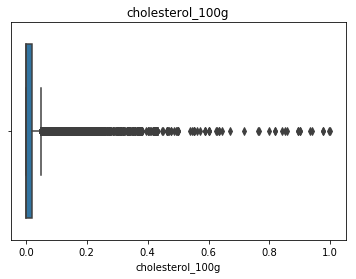

In [305]:
plot_boxplot(food_fats_df,'cholesterol_100g')

In [306]:
saveFinalDF(food_fats_df)

Saved module: food


### fat\_100g

In [307]:
non_null_num(food_fats_df,'fat_100g')
food_df[food_fats_df['fat_100g'].notnull()][['fat_100g']].describe()

Total number of not null elements: 586719
Percentage of the total: 84.56


,fat_100g
count,586719.000000
mean,13.636445
std,112.227224
min,0.000000
25%,0.500000
50%,6.300000
75%,21.000000
max,66700.000000


In [308]:
indexes_fat = food_fats_df.loc[food_fats_df['fat_100g'] > 100].index
high_values(indexes_fat, food_fats_df, 'fat_100g',1000)
food_fats_df.fat_100g.describe()

count    612298.000000
mean         13.264790
std          17.423974
min           0.000000
25%           0.500000
50%           6.300000
75%          21.000000
max         100.000000
Name: fat_100g, dtype: float64

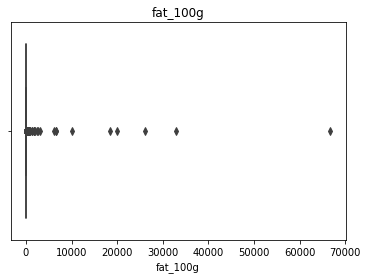

In [309]:
plot_boxplot(food_df,'fat_100g')

In [310]:
saveFinalDF(food_fats_df)

Saved module: food


### proteins\_100g

In [312]:
non_null_num(food_fats_df,'proteins_100g')
food_fats_df[food_fats_df['proteins_100g'].notnull()][['proteins_100g']].describe()

Total number of not null elements: 616939
Percentage of the total: 85.02


,proteins_100g
count,616939.000000
mean,8.126250
std,63.054967
min,-800.000000
25%,1.000000
50%,5.400000
75%,11.000000
max,31000.000000


The products whose protein value is negative we multiplied that value times -1 and then divided by 1000. 

In [313]:
indexes_neg = food_fats_df.loc[(food_fats_df['proteins_100g'] < 0 )].index
negative_values(indexes_neg, food_fats_df, 'proteins_100g') 
indexes_high = food_fats_df.loc[(food_fats_df['proteins_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'proteins_100g',1000)
food_fats_df.proteins_100g.describe()

count    616939.000000
mean          7.834707
std           9.155626
min           0.000000
25%           1.000000
50%           5.400000
75%          11.000000
max         100.000000
Name: proteins_100g, dtype: float64

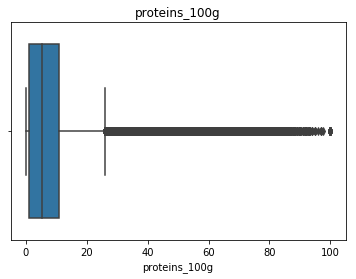

In [314]:
plot_boxplot(food_fats_df,'proteins_100g')

In [315]:
saveFinalDF(food_fats_df)

Saved module: food


### fiber\_100g

In [316]:
non_null_num(food_fats_df,'fiber_100g')
food_fats_df[food_fats_df['fiber_100g'].notnull()][['fiber_100g']].describe()

Total number of not null elements: 287409
Percentage of the total: 39.61


,fiber_100g
count,2.874090e+05
mean,1.939102e+04
std,1.038975e+07
min,-2.000000e+01
25%,0.000000e+00
50%,1.500000e+00
75%,3.600000e+00
max,5.570000e+09


In [317]:
indexes_neg = food_fats_df.loc[(food_fats_df['fiber_100g'] < 0 )].index
negative_values(indexes_neg, food_fats_df, 'fiber_100g') 
indexes_high = food_fats_df.loc[(food_fats_df['fiber_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'fiber_100g',100000000)
food_fats_df.fiber_100g.describe()

count    287409.000000
mean          2.943669
std           4.969576
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

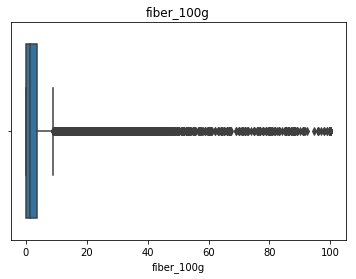

In [318]:
plot_boxplot(food_fats_df,'fiber_100g')

In [319]:
saveFinalDF(food_fats_df)

Saved module: food


### carbohydrates\_100g

In [320]:
non_null_num(food_fats_df,'carbohydrates_100g')
food_fats_df[food_fats_df['carbohydrates_100g'].notnull()][['carbohydrates_100g']].describe()

Total number of not null elements: 611990
Percentage of the total: 84.33


,carbohydrates_100g
count,611990.000000
mean,31.092314
std,273.023062
min,0.000000
25%,4.000000
50%,16.800000
75%,55.000000
max,86700.000000


In [321]:
indexes_high = food_fats_df.loc[(food_fats_df['carbohydrates_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'carbohydrates_100g',1000)
food_fats_df.carbohydrates_100g.describe()

count    611990.000000
mean         29.408667
std          28.547073
min           0.000000
25%           4.000000
50%          16.700000
75%          55.000000
max         100.000000
Name: carbohydrates_100g, dtype: float64

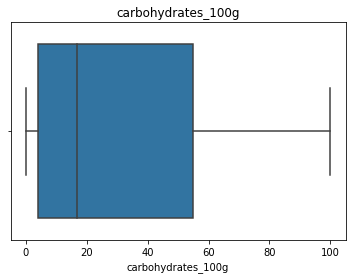

In [322]:
plot_boxplot(food_fats_df,'carbohydrates_100g')

In [323]:
saveFinalDF(food_fats_df)

Saved module: food


### sugars\_100g

In [324]:
non_null_num(food_fats_df,'sugars_100g')
food_fats_df[food_fats_df['sugars_100g'].notnull()][['sugars_100g']].describe()

Total number of not null elements: 601822
Percentage of the total: 82.93


,sugars_100g
count,601822.000000
mean,15.832136
std,195.525618
min,-17.860000
25%,0.880000
50%,4.500000
75%,22.000000
max,86700.000000


In [325]:
indexes_neg = food_fats_df.loc[(food_fats_df['sugars_100g'] < 0 )].index
negative_values(indexes_neg, food_fats_df, 'sugars_100g') 
indexes_high = food_fats_df.loc[(food_fats_df['sugars_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'sugars_100g',1000)
food_fats_df.sugars_100g.describe()

count    601822.000000
mean         14.805177
std          20.636707
min           0.000000
25%           0.880000
50%           4.500000
75%          22.000000
max         100.000000
Name: sugars_100g, dtype: float64

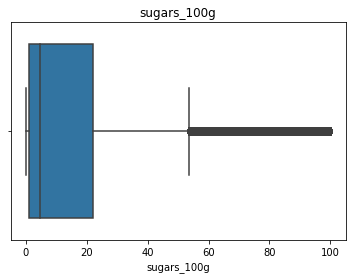

In [326]:
plot_boxplot(food_fats_df,'sugars_100g')

In [327]:
saveFinalDF(food_fats_df)

Saved module: food


### salt\_100g

In [328]:
non_null_num(food_fats_df,'salt_100g')
food_fats_df[food_fats_df['salt_100g'].notnull()][['salt_100g']].describe()

Total number of not null elements: 596198
Percentage of the total: 82.16


,salt_100g
count,596198.000000
mean,3.859569
std,674.003077
min,0.000000
25%,0.063500
50%,0.530000
75%,1.323340
max,348000.000000


In [329]:
indexes_high = food_fats_df.loc[(food_fats_df['salt_100g'] >100 )].index
high_values(indexes_high, food_fats_df, 'salt_100g',1000)
indexes_high = food_fats_df.loc[(food_fats_df['salt_100g'] >100 )].index
high_values(indexes_high, food_fats_df, 'salt_100g',10)
food_fats_df.salt_100g.describe()

count    596198.000000
mean          1.469457
std           5.798315
min           0.000000
25%           0.063500
50%           0.530000
75%           1.320000
max         100.000000
Name: salt_100g, dtype: float64

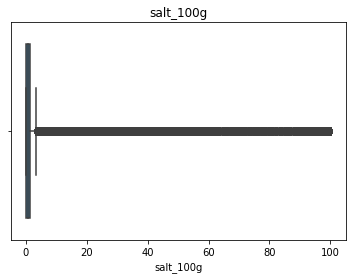

In [330]:
plot_boxplot(food_fats_df,'salt_100g')

In [331]:
saveFinalDF(food_fats_df)

Saved module: food


### sodium\_100g

In [332]:
non_null_num(food_fats_df,'sodium_100g')
food_fats_df[food_fats_df['sodium_100g'].notnull()][['sodium_100g']].describe()

Total number of not null elements: 596161
Percentage of the total: 82.15


,sodium_100g
count,596161.000000
mean,1.519606
std,265.343088
min,0.000000
25%,0.025000
50%,0.208661
75%,0.521000
max,137000.000000


In [333]:
indexes_high = food_fats_df.loc[(food_fats_df['sodium_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'sodium_100g',1000)
indexes_high = food_fats_df.loc[(food_fats_df['sodium_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'sodium_100g',10)
food_fats_df.sodium_100g.describe()

count    596161.000000
mean          0.594488
std           2.472043
min           0.000000
25%           0.025000
50%           0.208661
75%           0.520000
max         100.000000
Name: sodium_100g, dtype: float64

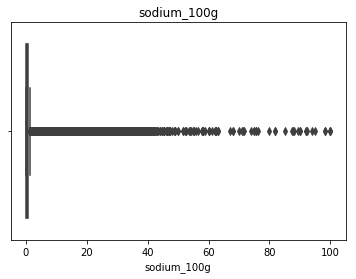

In [334]:
plot_boxplot(food_fats_df,'sodium_100g')

### alcohol\_100g

In [335]:
non_null_num(food_fats_df,'alcohol_100g')
food_fats_df[food_fats_df['alcohol_100g'].notnull()][['alcohol_100g']].describe()

Total number of not null elements: 8817
Percentage of the total: 1.21


,alcohol_100g
count,8817.000000
mean,7.006841
std,10.467670
min,0.000000
25%,0.000000
50%,4.500000
75%,11.500000
max,100.000000


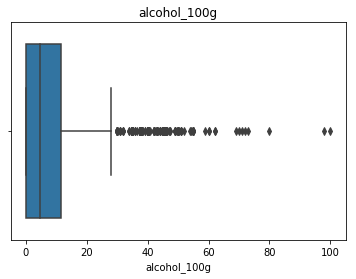

In [336]:
plot_boxplot(food_fats_df,'alcohol_100g')

### calcium_100g

In [337]:
non_null_num(food_fats_df,'calcium_100g')
food_fats_df[food_fats_df['calcium_100g'].notnull()][['calcium_100g']].describe()

Total number of not null elements: 145476
Percentage of the total: 20.05


,calcium_100g
count,145476.000000
mean,0.194769
std,5.783936
min,0.000000
25%,0.000000
50%,0.036000
75%,0.113000
max,779.000000


In [338]:
indexes_high = food_fats_df.loc[(food_fats_df['calcium_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'calcium_100g',1000)
food_fats_df.calcium_100g.describe()

count    145476.000000
mean          0.111612
std           0.889091
min           0.000000
25%           0.000000
50%           0.036000
75%           0.113000
max         100.000000
Name: calcium_100g, dtype: float64

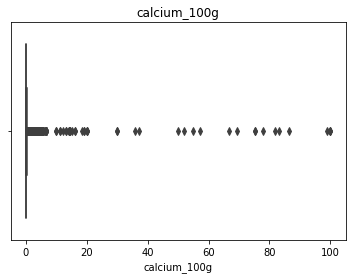

In [339]:
plot_boxplot(food_fats_df,'calcium_100g')

In [340]:
saveFinalDF(food_fats_df)

Saved module: food


### iron_100g

In [341]:
non_null_num(food_fats_df,'iron_100g')
food_fats_df[food_fats_df['iron_100g'].notnull()][['iron_100g']].describe()

Total number of not null elements: 143104
Percentage of the total: 19.72


,iron_100g
count,143104.000000
mean,0.006156
std,0.382455
min,-0.000260
25%,0.000000
50%,0.001030
75%,0.002470
max,96.000000


In [342]:
indexes_neg = food_fats_df.loc[(food_fats_df['iron_100g'] < 0 )].index
negative_values(indexes_neg, food_fats_df, 'iron_100g') 
food_fats_df.iron_100g.describe()

count    143104.000000
mean          0.006156
std           0.382455
min           0.000000
25%           0.000000
50%           0.001030
75%           0.002470
max          96.000000
Name: iron_100g, dtype: float64

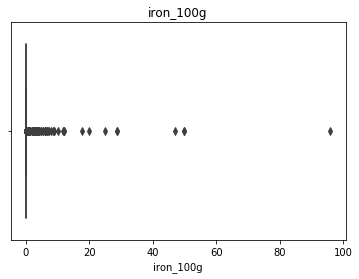

In [343]:
plot_boxplot(food_fats_df,'iron_100g')

### satured-fat_100g

In [344]:
non_null_num(food_fats_df,'saturated-fat_100g')
food_fats_df[food_fats_df['saturated-fat_100g'].notnull()][['saturated-fat_100g']].describe()

Total number of not null elements: 586464
Percentage of the total: 80.82


,saturated-fat_100g
count,586464.000000
mean,5.353033
std,41.648477
min,0.000000
25%,0.100000
50%,1.800000
75%,7.350000
max,18000.000000


In [358]:
indexes_high = food_fats_df.loc[(food_fats_df['saturated-fat_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'saturated-fat_100g',1000)
food_fats_df['saturated-fat_100g'].describe()

count    586464.000000
mean          5.165214
std           7.895768
min           0.000000
25%           0.100000
50%           1.800000
75%           7.350000
max         100.000000
Name: saturated-fat_100g, dtype: float64

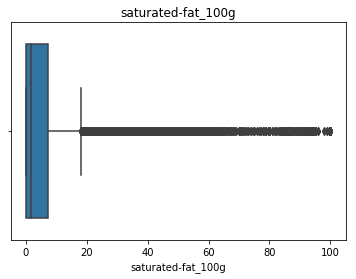

In [346]:
plot_boxplot(food_fats_df,'saturated-fat_100g')

In [347]:
saveFinalDF(food_fats_df)

Saved module: food


### trans-fat_100g

In [348]:
non_null_num(food_fats_df,'trans-fat_100g')
food_fats_df[food_fats_df['trans-fat_100g'].notnull()][['trans-fat_100g']].describe()

Total number of not null elements: 145274
Percentage of the total: 20.02


,trans-fat_100g
count,145274.000000
mean,0.074120
std,1.540436
min,-3.570000
25%,0.000000
50%,0.000000
75%,0.000000
max,369.000000


In [359]:
indexes_neg = food_fats_df.loc[(food_fats_df['trans-fat_100g'] < 0 )].index
negative_values(indexes_neg, food_fats_df, 'trans-fat_100g') 
indexes_high = food_fats_df.loc[(food_fats_df['trans-fat_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'trans-fat_100g',1000)
food_fats_df['trans-fat_100g'].describe()

count    145274.000000
mean          0.067961
std           0.956005
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: trans-fat_100g, dtype: float64

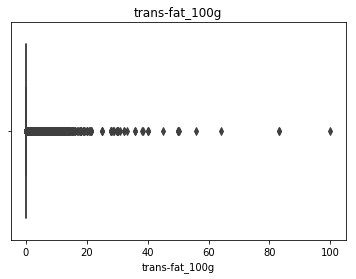

In [350]:
plot_boxplot(food_fats_df,'trans-fat_100g')

### energy_100g

In [354]:
non_null_num(food_fats_df,'energy_100g')
food_fats_df[food_fats_df['energy_100g'].notnull()][['energy_100g']].describe()

Total number of not null elements: 618151
Percentage of the total: 85.18


,energy_100g
count,6.181510e+05
mean,7.840435e+02
std,3.182745e+03
min,0.000000e+00
25%,1.674000e-01
50%,4.520000e+02
75%,1.452000e+03
max,1.790000e+06


In [368]:
indexes_high = food_fats_df.loc[(food_fats_df['energy_100g'] > 100 )].index
high_values(indexes_high, food_fats_df, 'energy_100g',10000)
food_fats_df['trans-fat_100g'].describe()

Progress 100.0%

count    145274.000000
mean          0.067961
std           0.956005
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: trans-fat_100g, dtype: float64

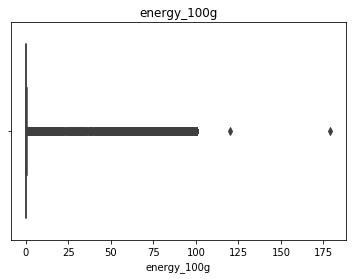

In [369]:
plot_boxplot(food_fats_df,'energy_100g')

In [370]:
saveFinalDF(food_fats_df)

Saved module: food


We are going to plot only non-zero values, so that, we implemented the above function that filer the values different from zero.

In [7]:
def before_plot (df, column):
    values = df.loc[(df[column] != 0.0 )][[column]]
    return values.sort_values(column, ascending=True)

In [5]:
desired_columns = ["cholesterol_100g",
                    "fat_100g",
                    "proteins_100g",
                    "fiber_100g",
                    "carbohydrates_100g",
                    "sugars_100g",
                    "salt_100g",
                    "sodium_100g",
                    "alcohol_100g",
                    "calcium_100g",
                    "iron_100g",
                    "saturated-fat_100g",
                    "trans-fat_100g",
                    "country_code"]
correlation_df = food_df[desired_columns]
correlation_df.head(5)

,cholesterol_100g,fat_100g,proteins_100g,fiber_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,alcohol_100g,calcium_100g,iron_100g,saturated-fat_100g,trans-fat_100g,country_code
0,NaN,7.0,7.8,NaN,70.1,15.0,1.40,0.551181,NaN,NaN,NaN,3.08,NaN,FRA
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA
2,NaN,0.0,0.2,NaN,4.8,0.4,2.04,0.803150,NaN,NaN,NaN,0.00,NaN,FRA
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA
4,NaN,0.3,0.9,NaN,5.3,3.9,0.42,0.165354,NaN,NaN,NaN,0.10,NaN,FRA


In [8]:
cholesterol = before_plot(countries_df,"cholesterol_100g")
fat = before_plot(countries_df, "fat_100g")
proteins = before_plot(countries_df, "proteins_100g")
fiber = before_plot(countries_df, "fiber_100g")
carbohydrates = before_plot(countries_df, "carbohydrates_100g")
sugars = before_plot(countries_df, "sugars_100g")
salt = before_plot(countries_df, "salt_100g")
sodium = before_plot(countries_df, "sodium_100g")
alcohol = before_plot(countries_df, "alcohol_100g")
calcium = before_plot(countries_df, "calcium_100g")
iron = before_plot(countries_df, "iron_100g")
saturated_fat = before_plot(countries_df, "saturated-fat_100g")
trans_fat = before_plot(countries_df, "trans-fat_100g")

In [9]:
def plot_barchar (df, column, label_name, color_code, color_bar, fig_size):
    sns.set(style="whitegrid") #style of the axes
    
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize = fig_size)
    
    # Plot the total crashes
    sns.set_color_codes(color_code)
    ax = sns.barplot(x=df[column], y=df.index, label=label_name, color=color_bar)
    
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="upper right", frameon=True)
    ax.set(xlim=(0, df[column].max()), ylabel="countries", xlabel=label_name)
    sns.despine(left=True, bottom=True)

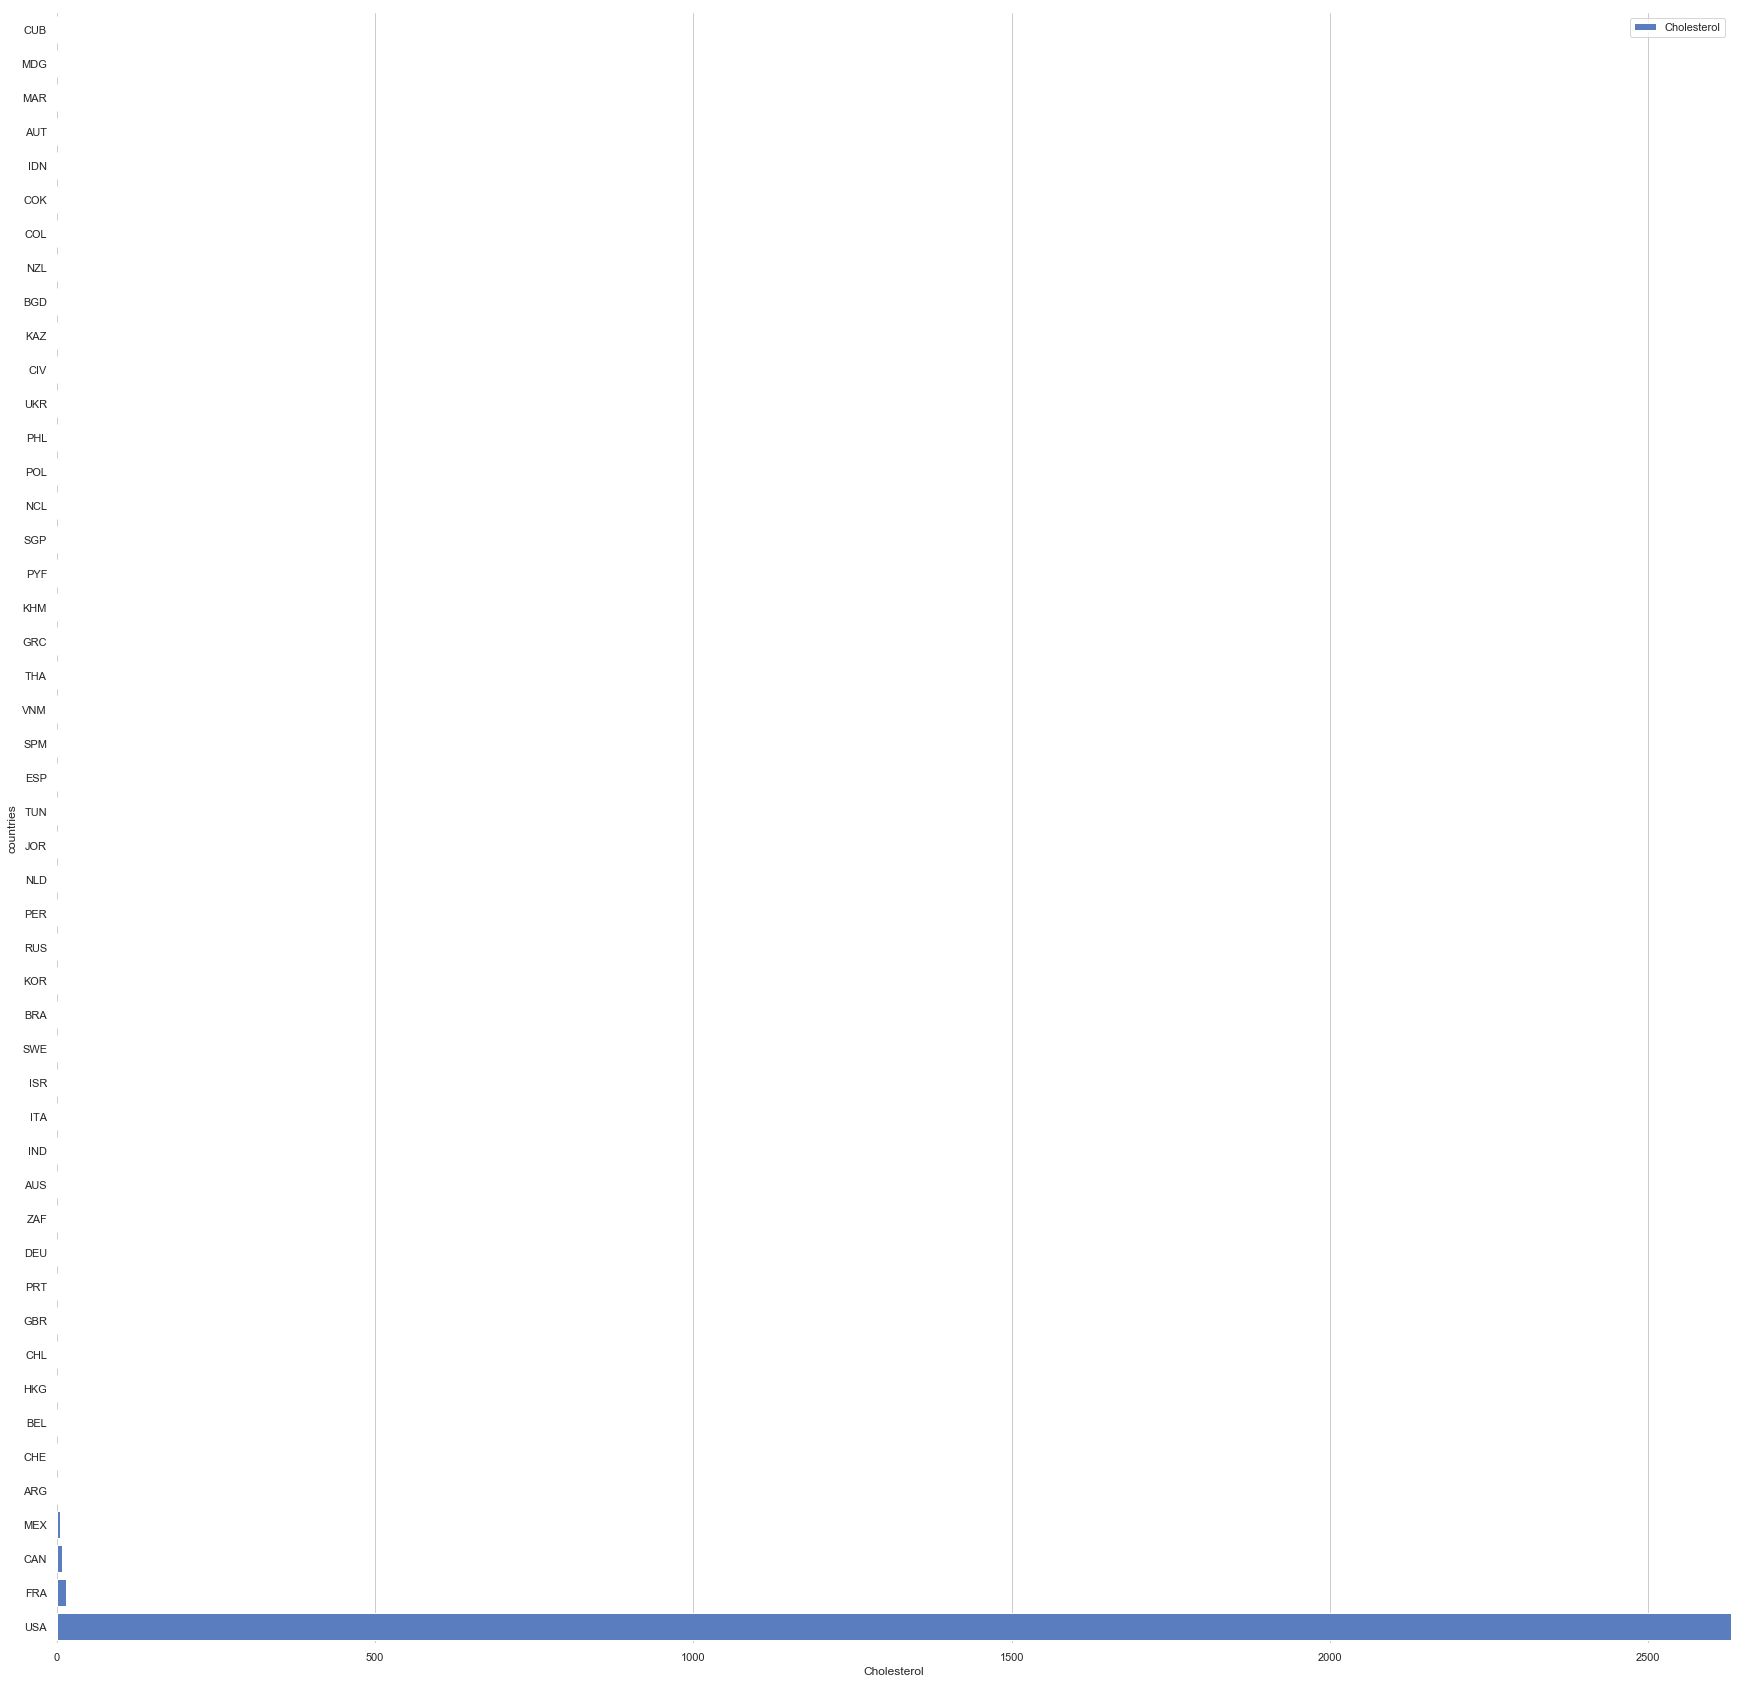

In [21]:
plot_barchar(cholesterol, "cholesterol_100g", "Cholesterol", "muted", "b", (30,30))

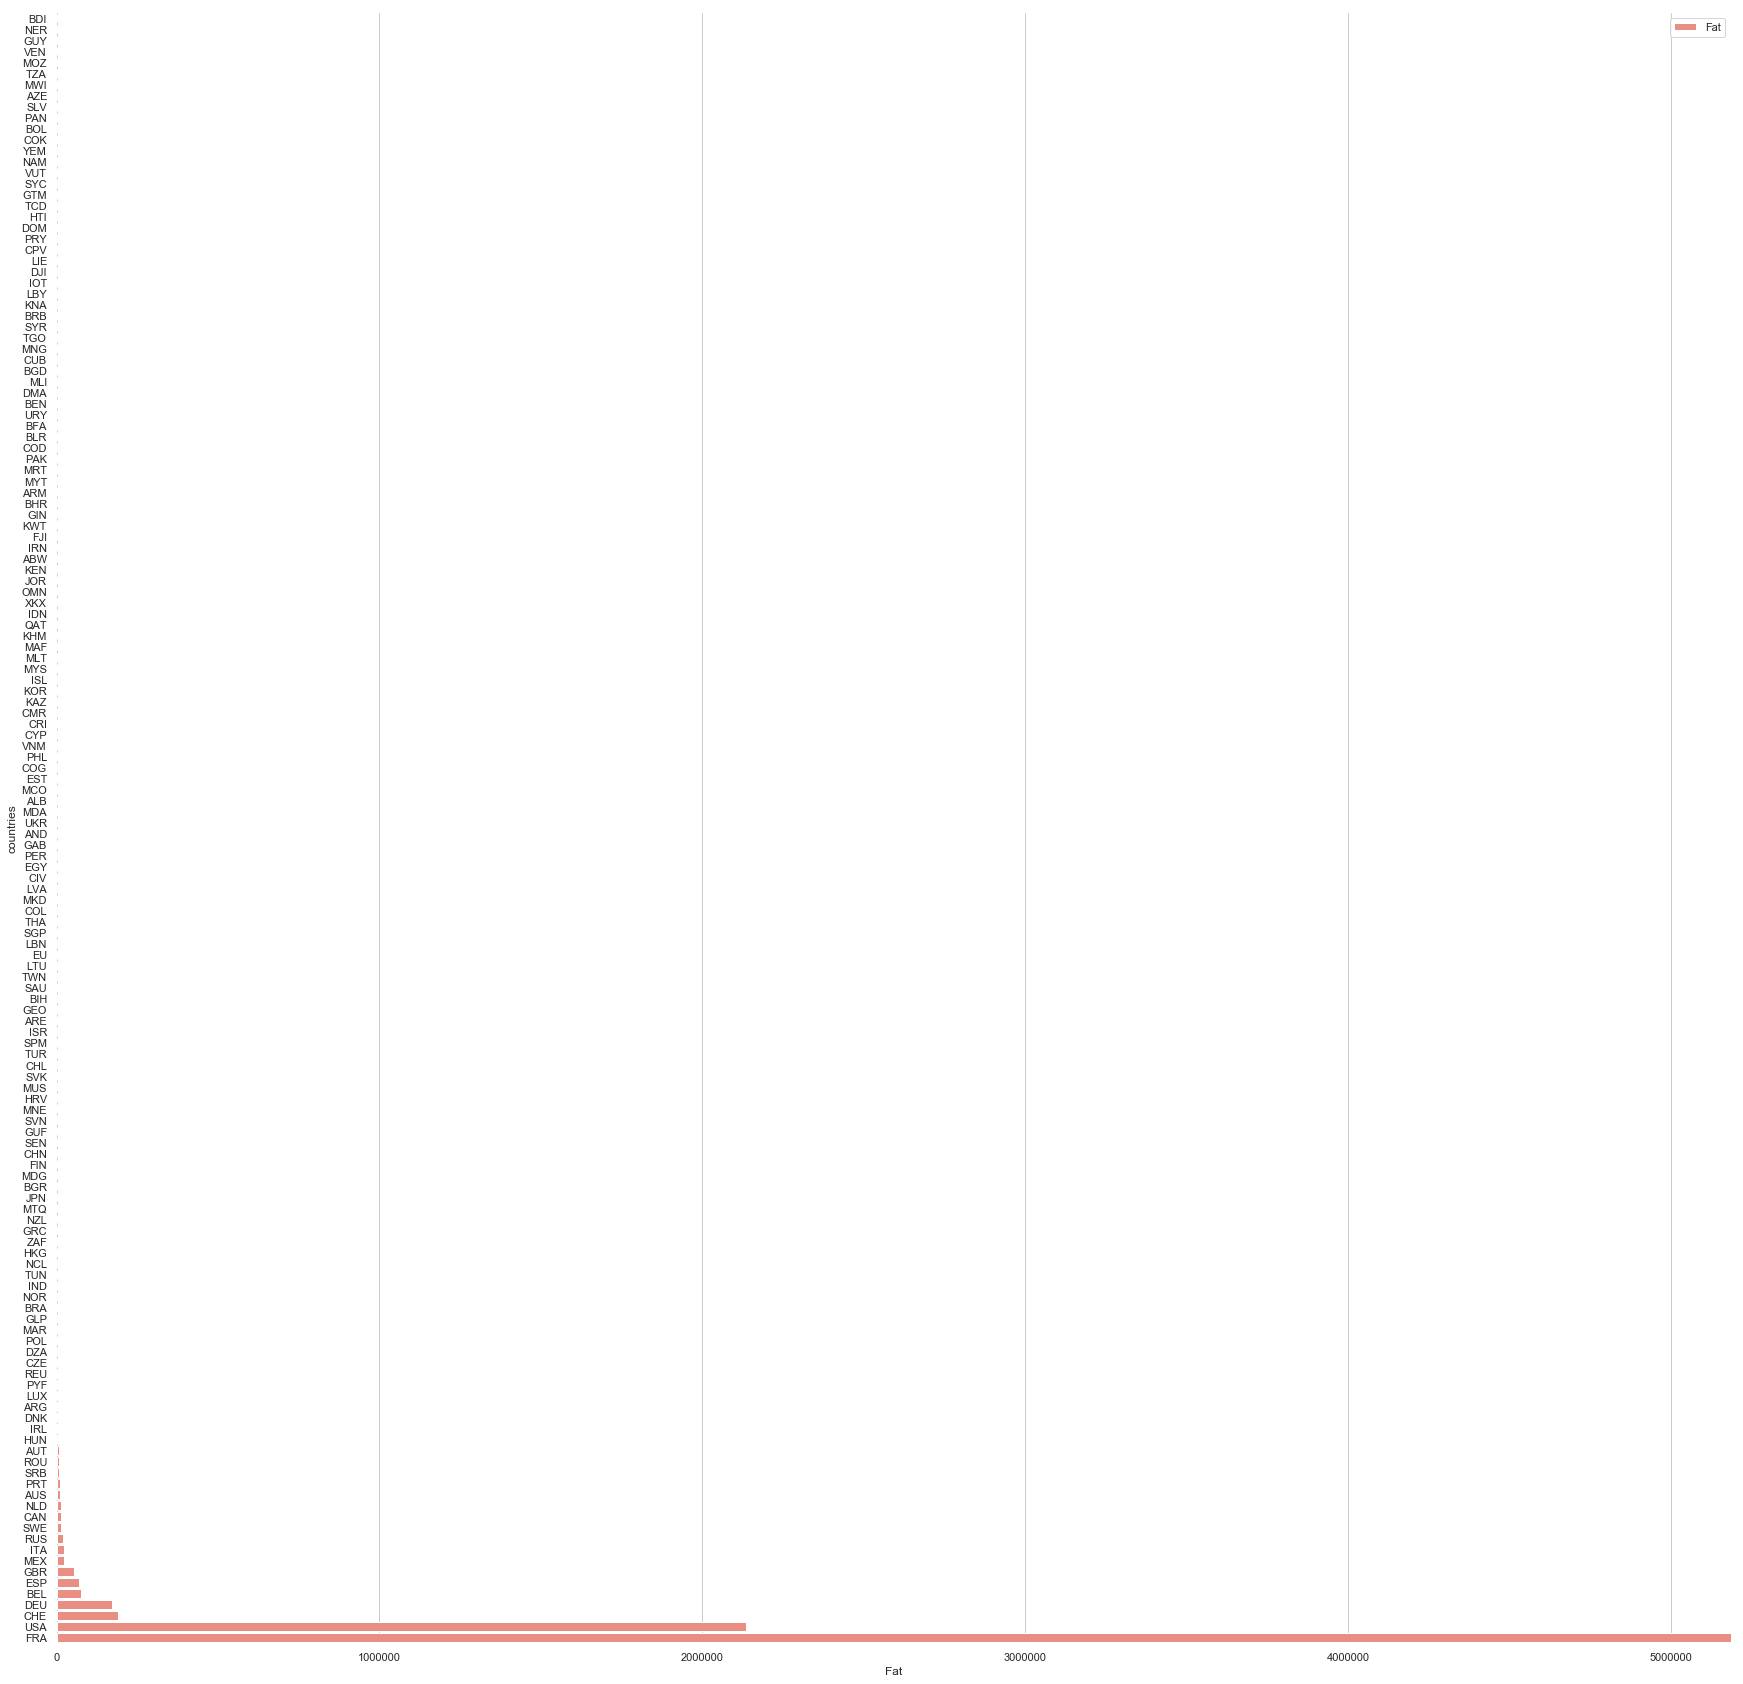

In [22]:
plot_barchar(fat, "fat_100g", "Fat", "muted", "salmon", (30,30))

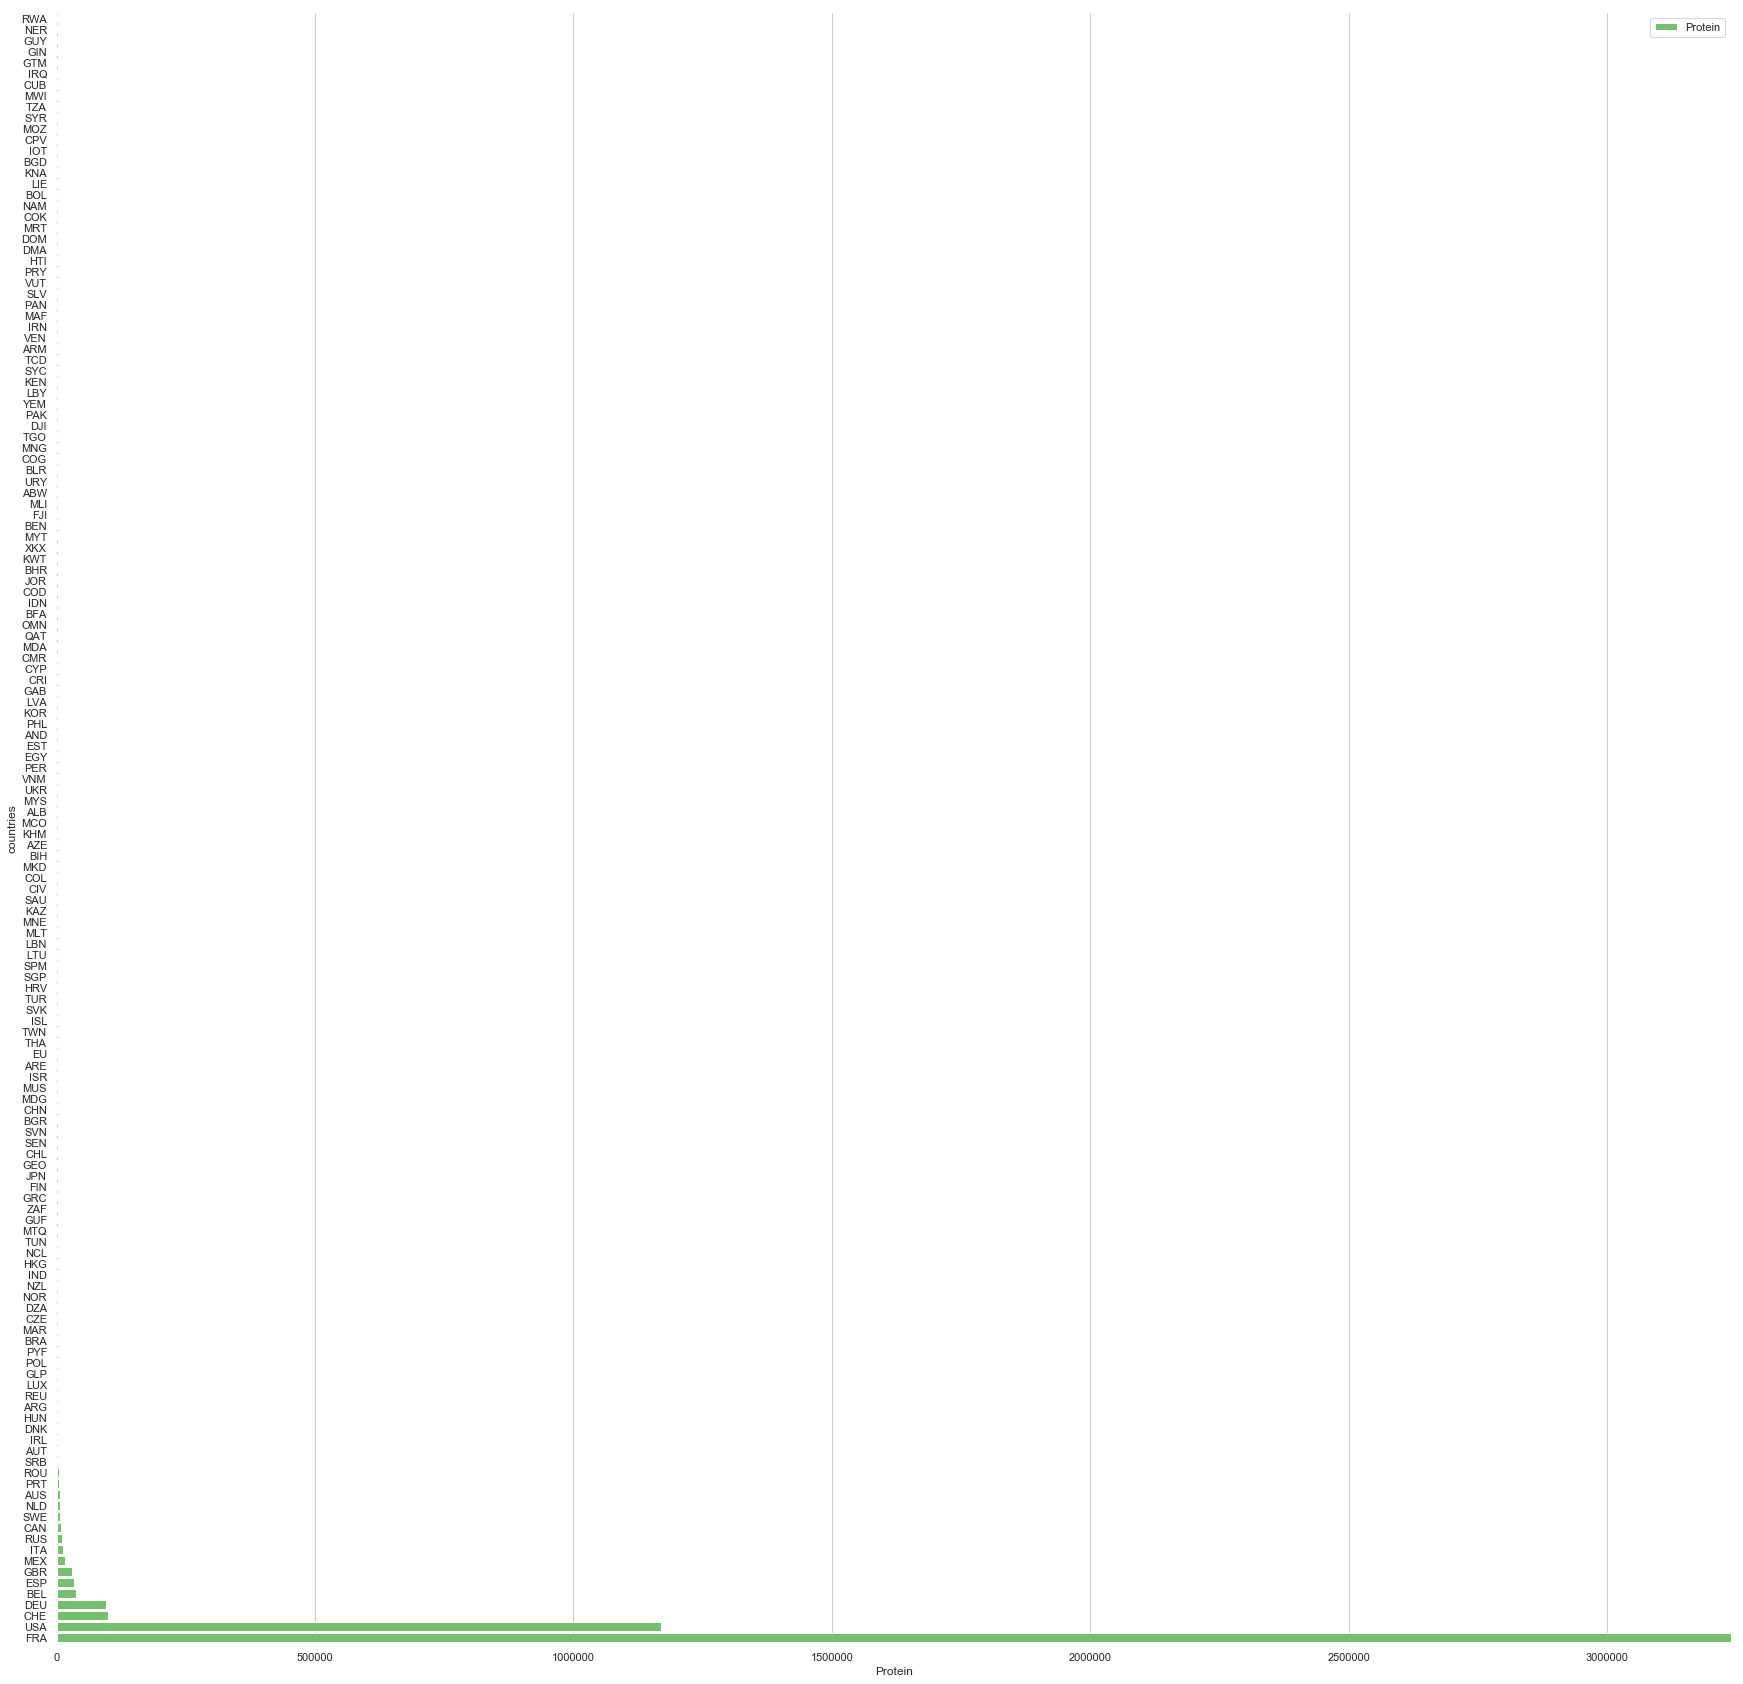

In [24]:
plot_barchar(proteins, "proteins_100g", "Protein", "muted", "g", (30,30))

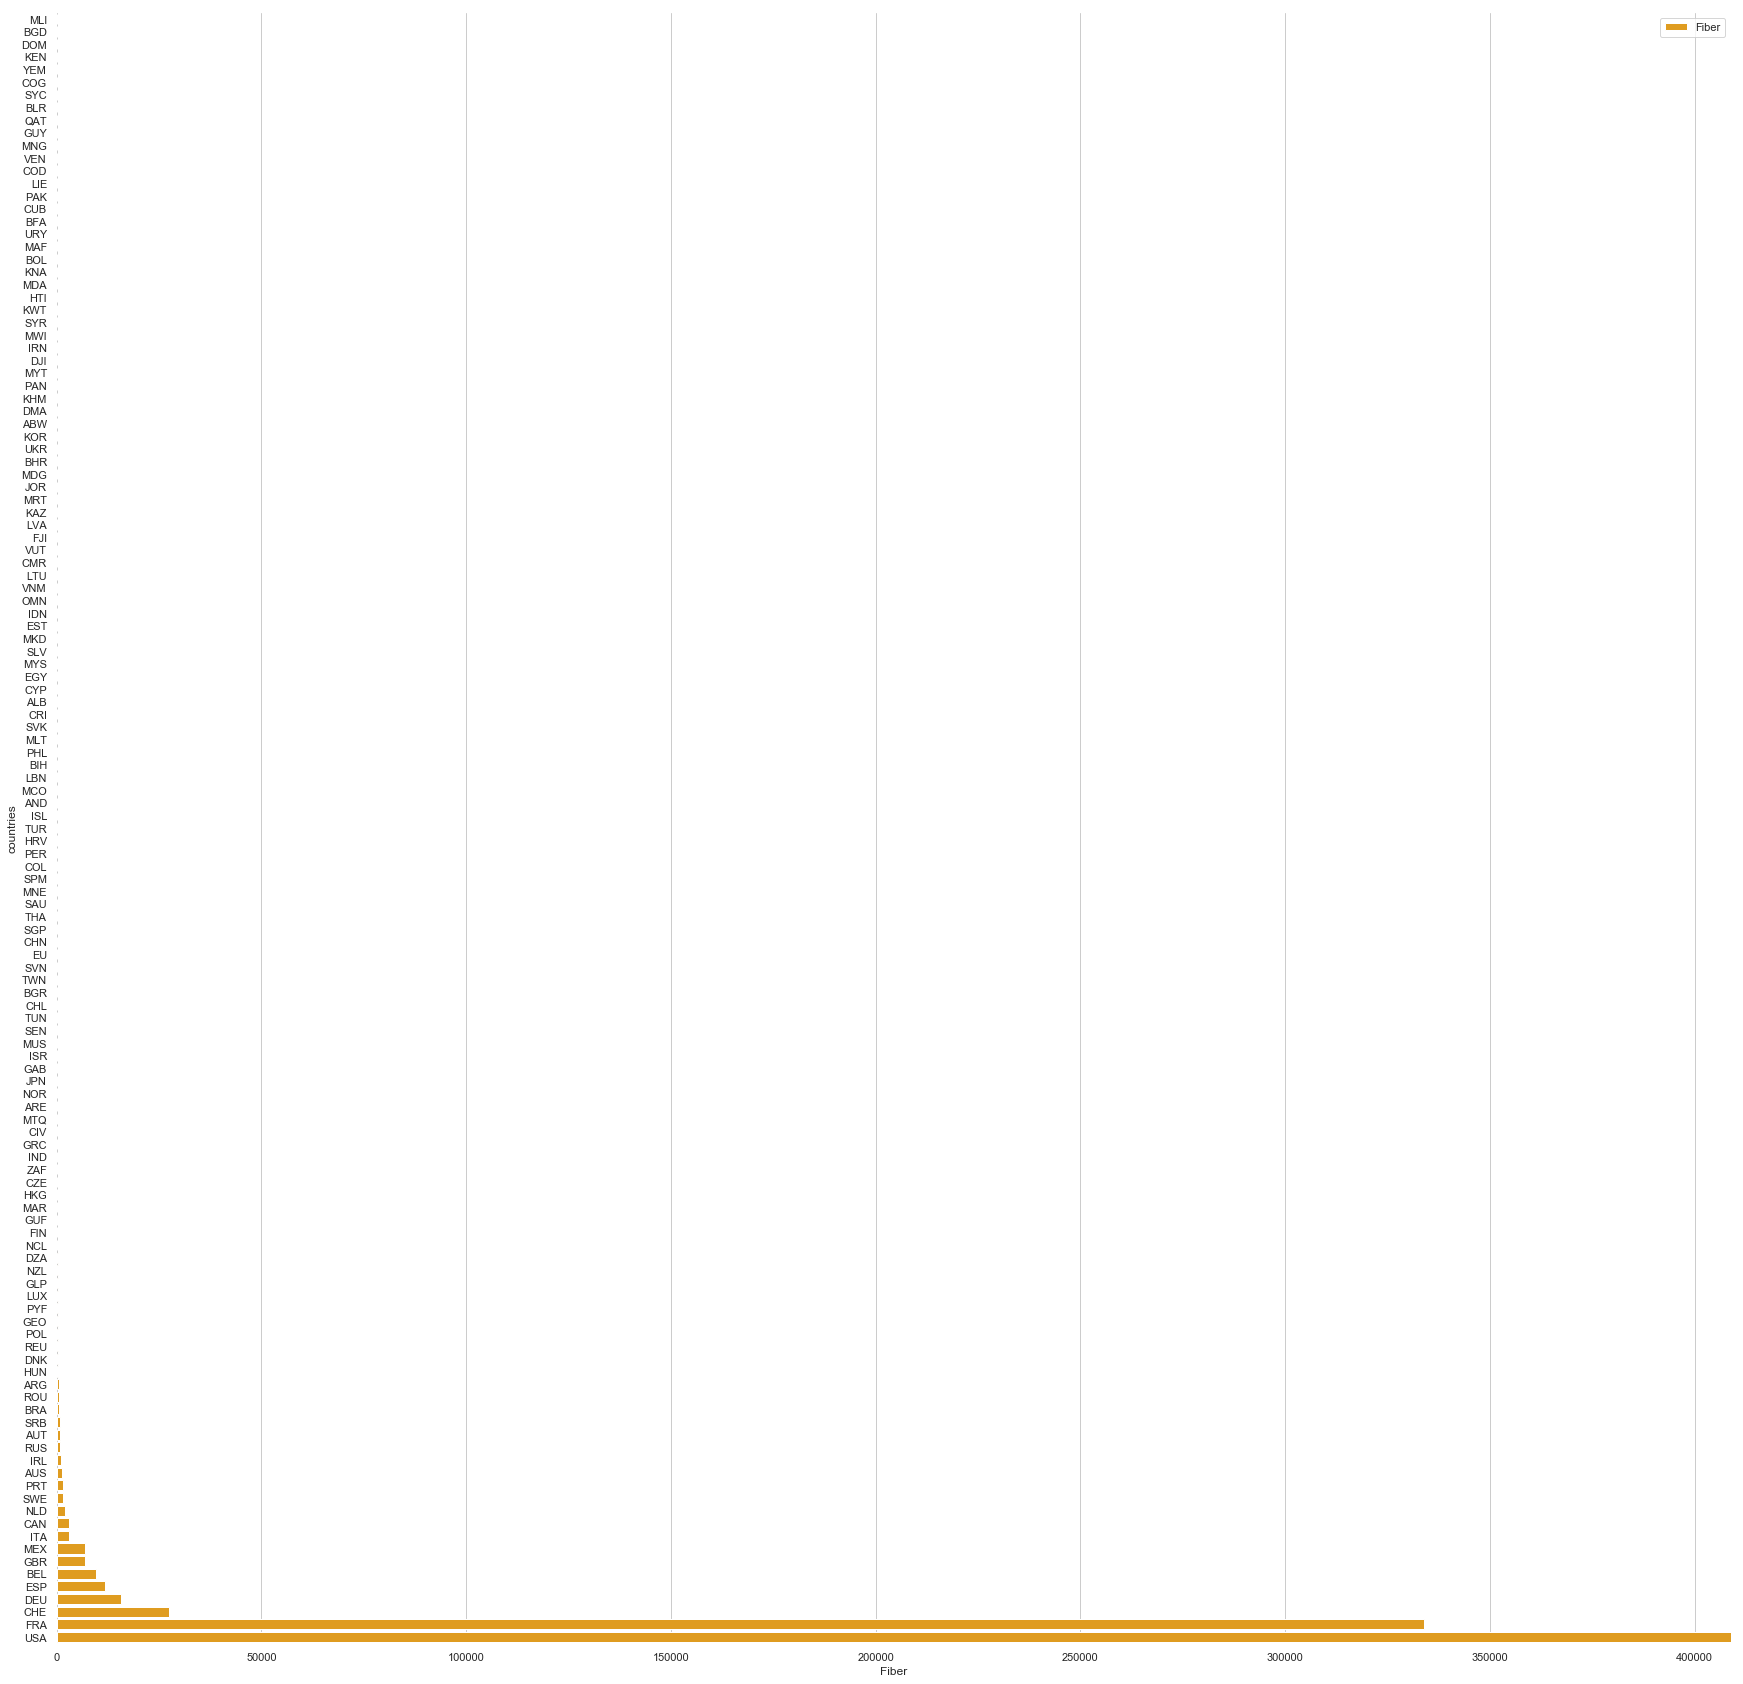

In [25]:
plot_barchar(fiber, "fiber_100g", "Fiber", "muted", "orange", (30,30))

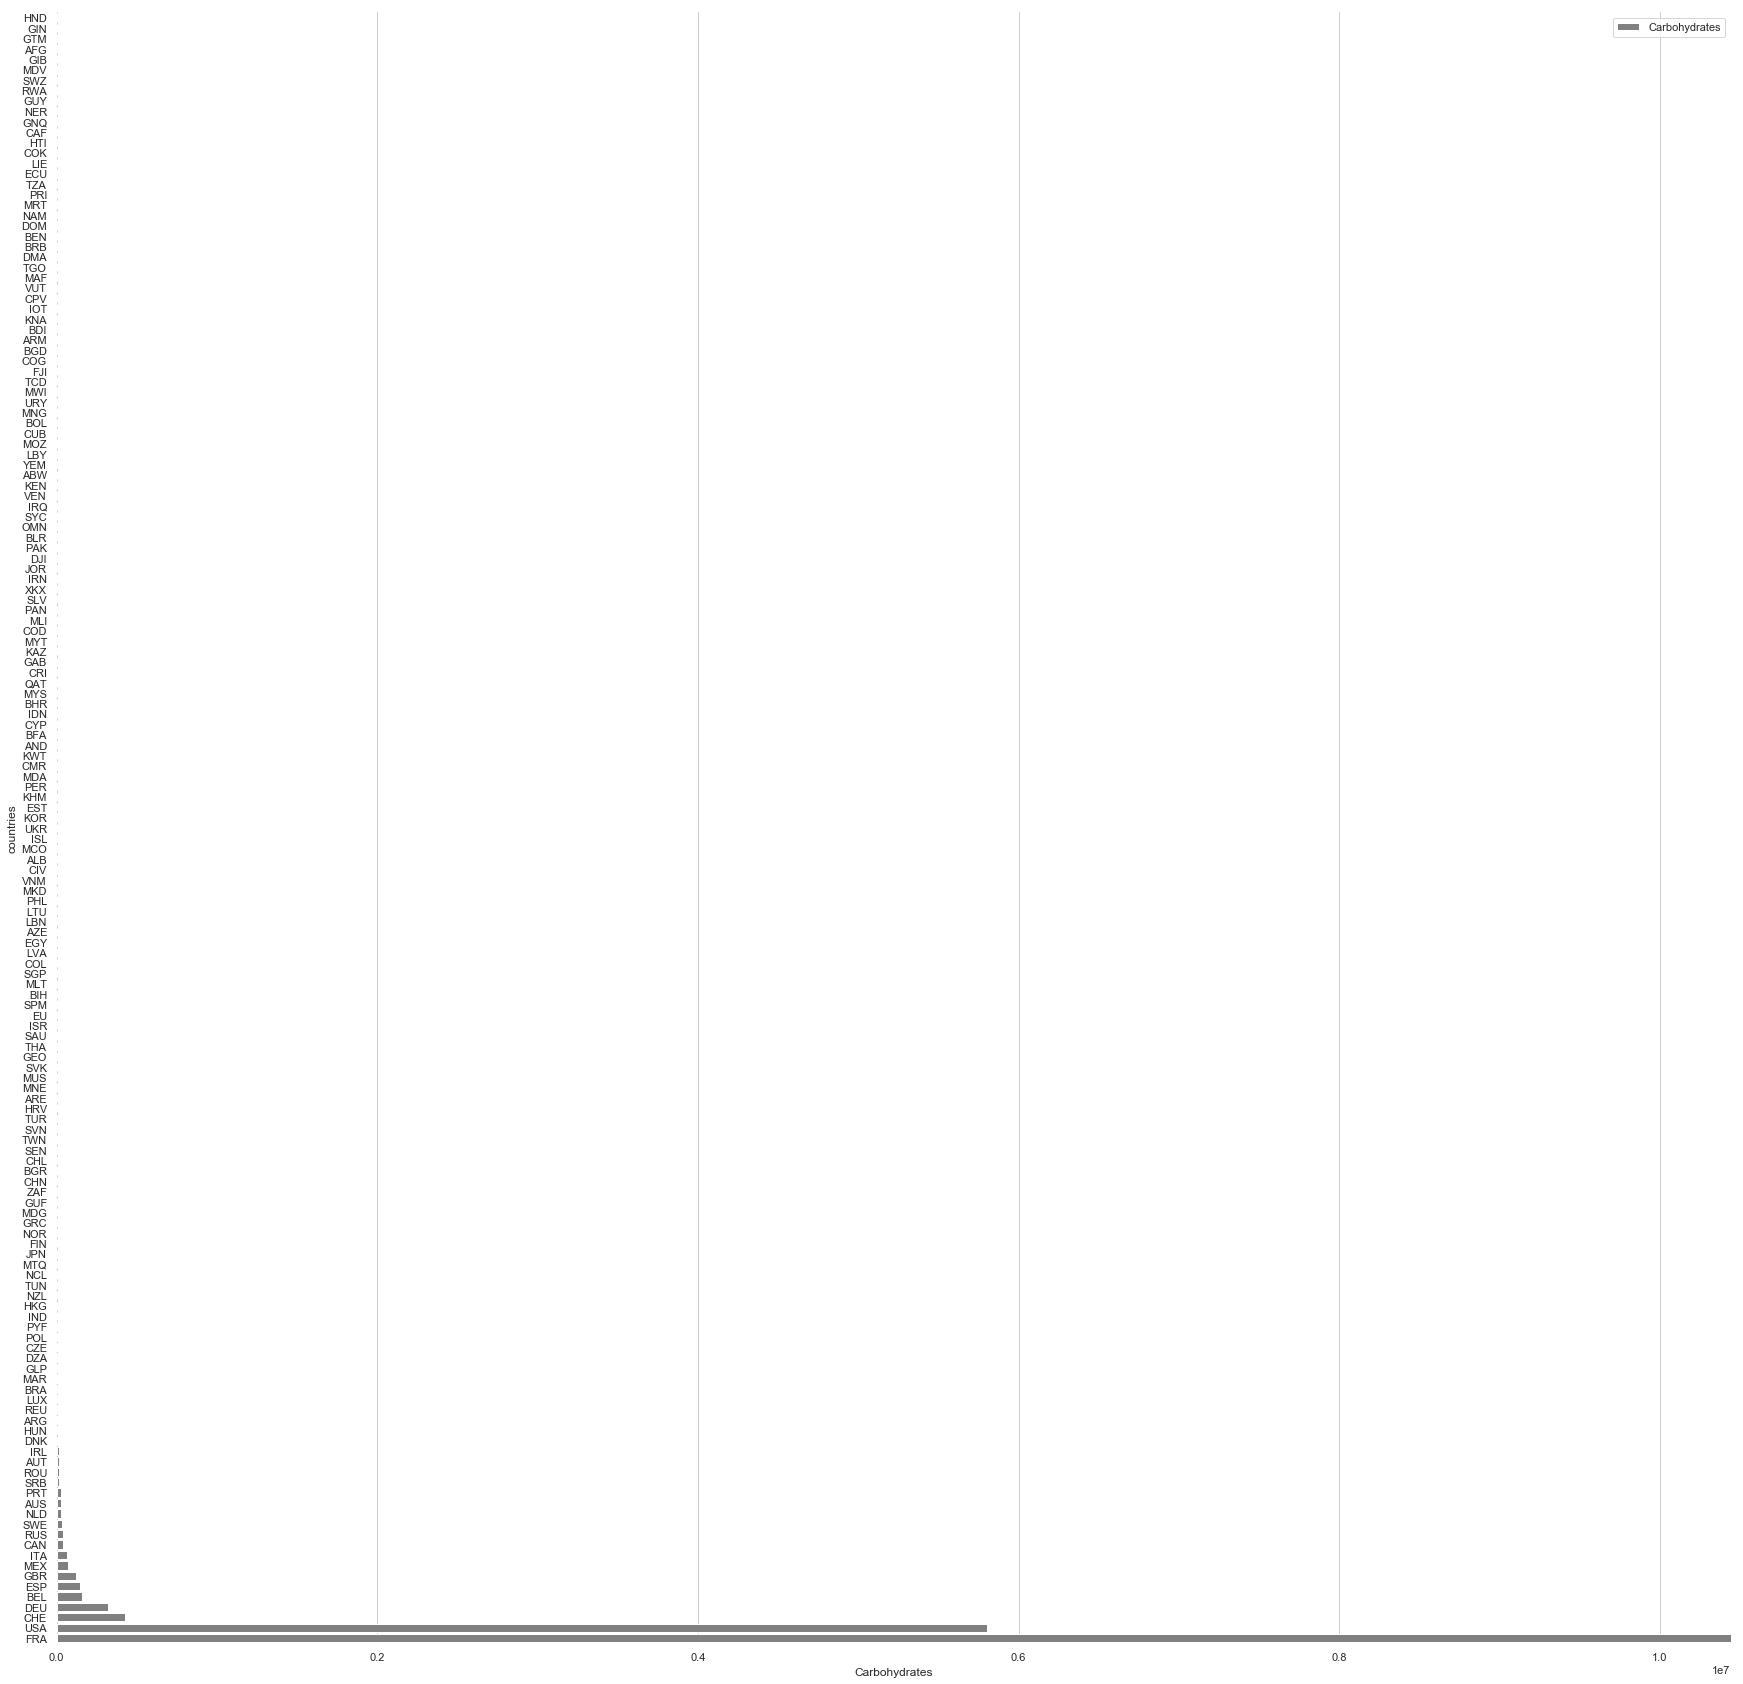

In [28]:
plot_barchar(carbohydrates, "carbohydrates_100g", "Carbohydrates","muted", "grey", (30,30))

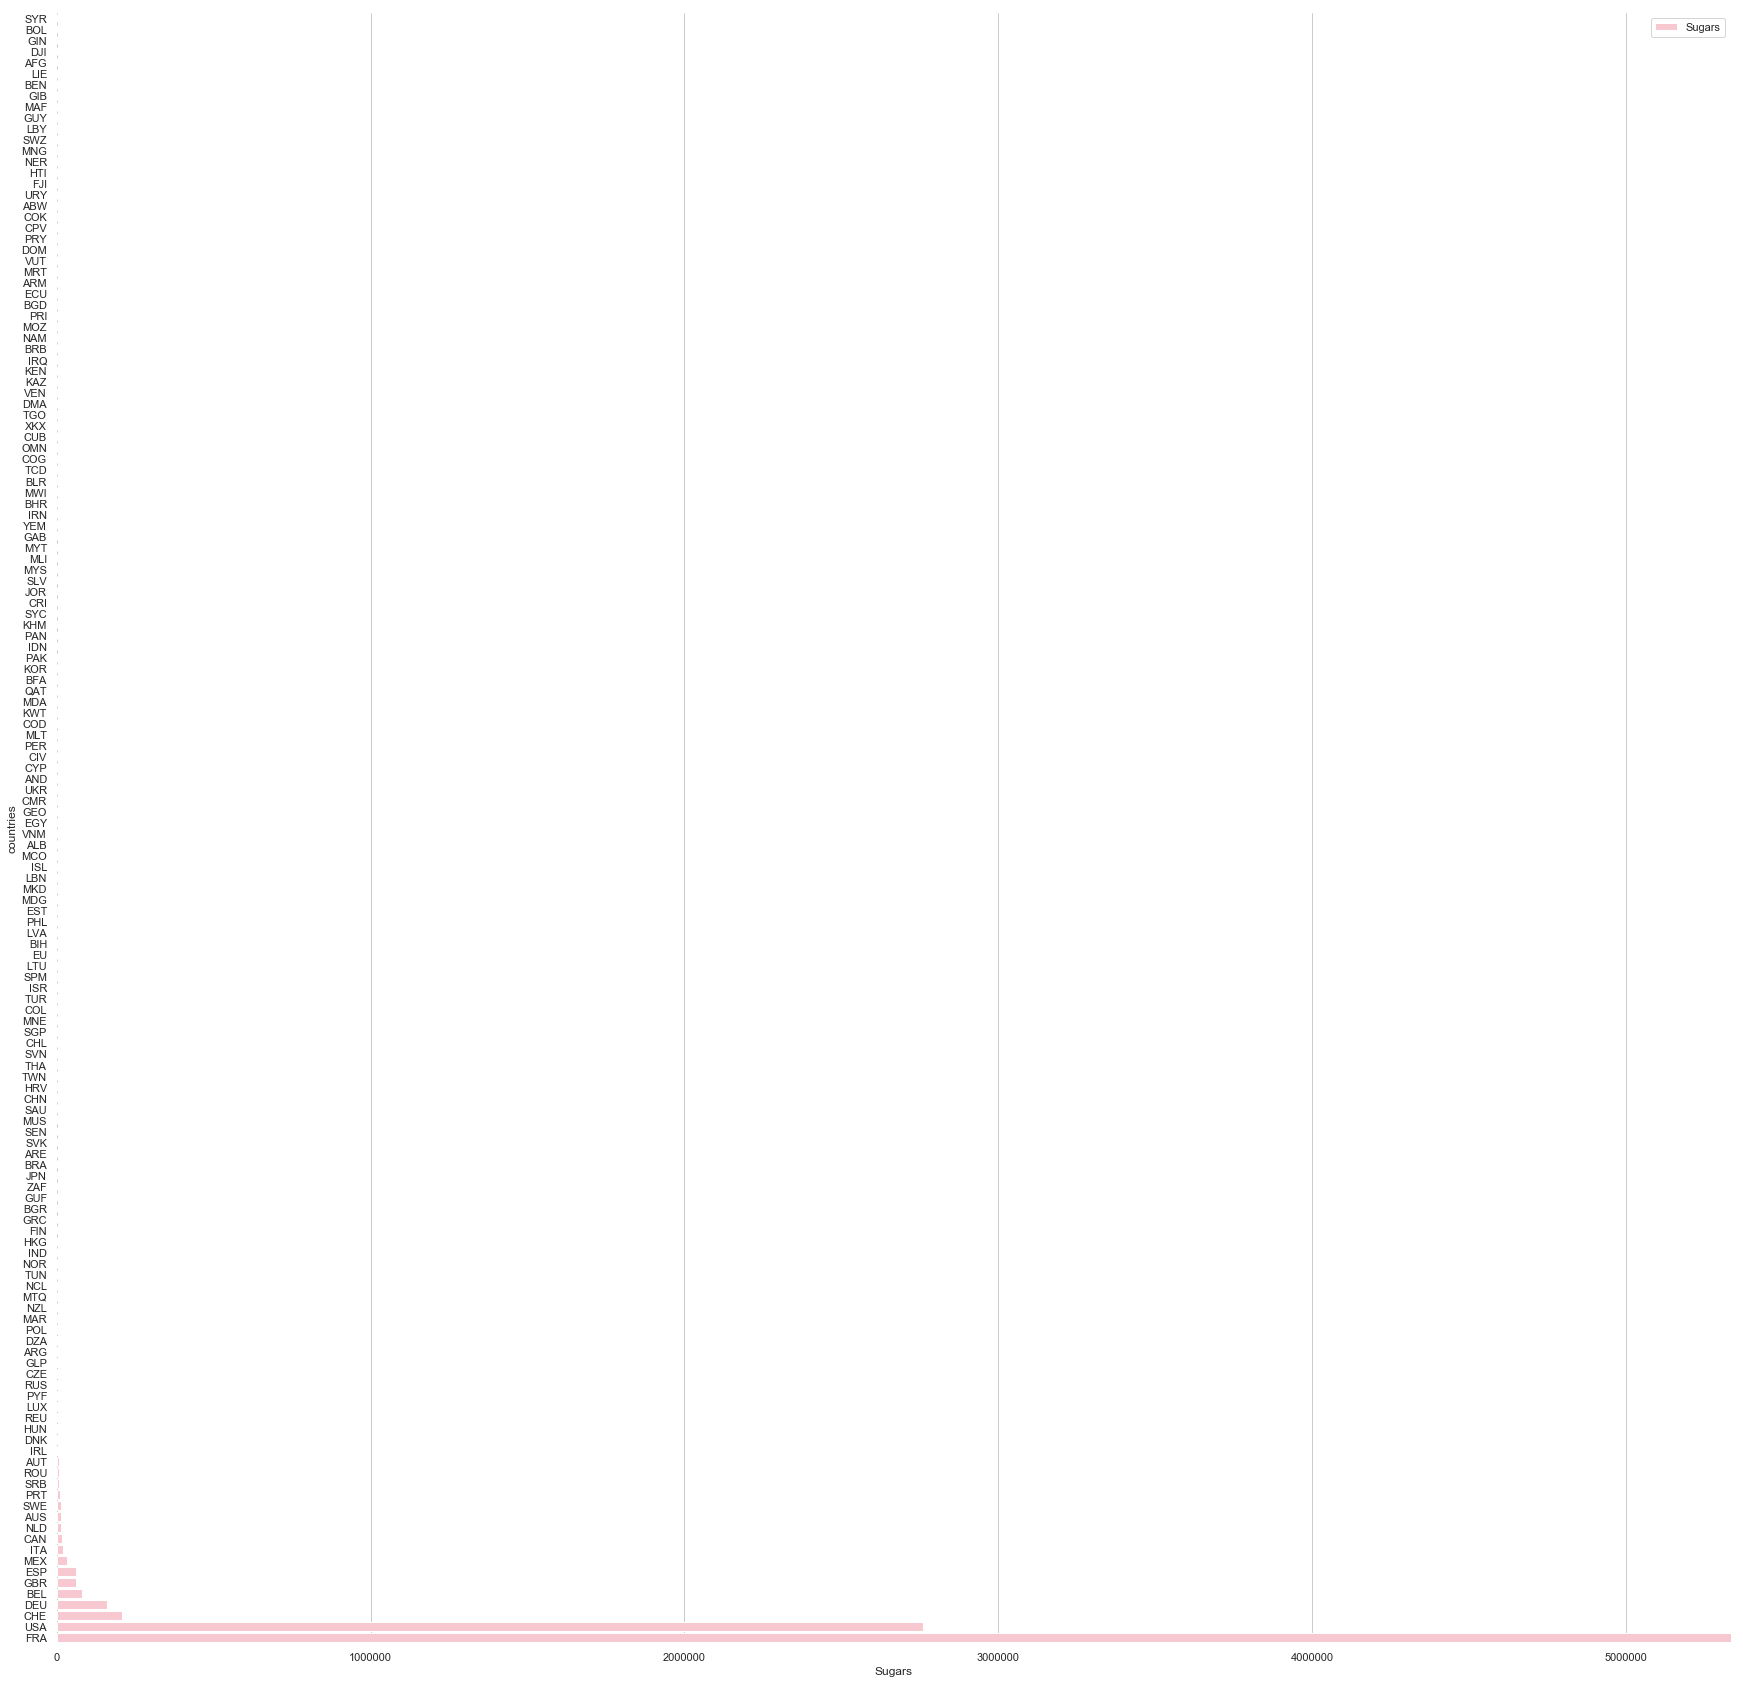

In [29]:
plot_barchar(sugars, "sugars_100g", "Sugars", "muted", "pink", (30,30))

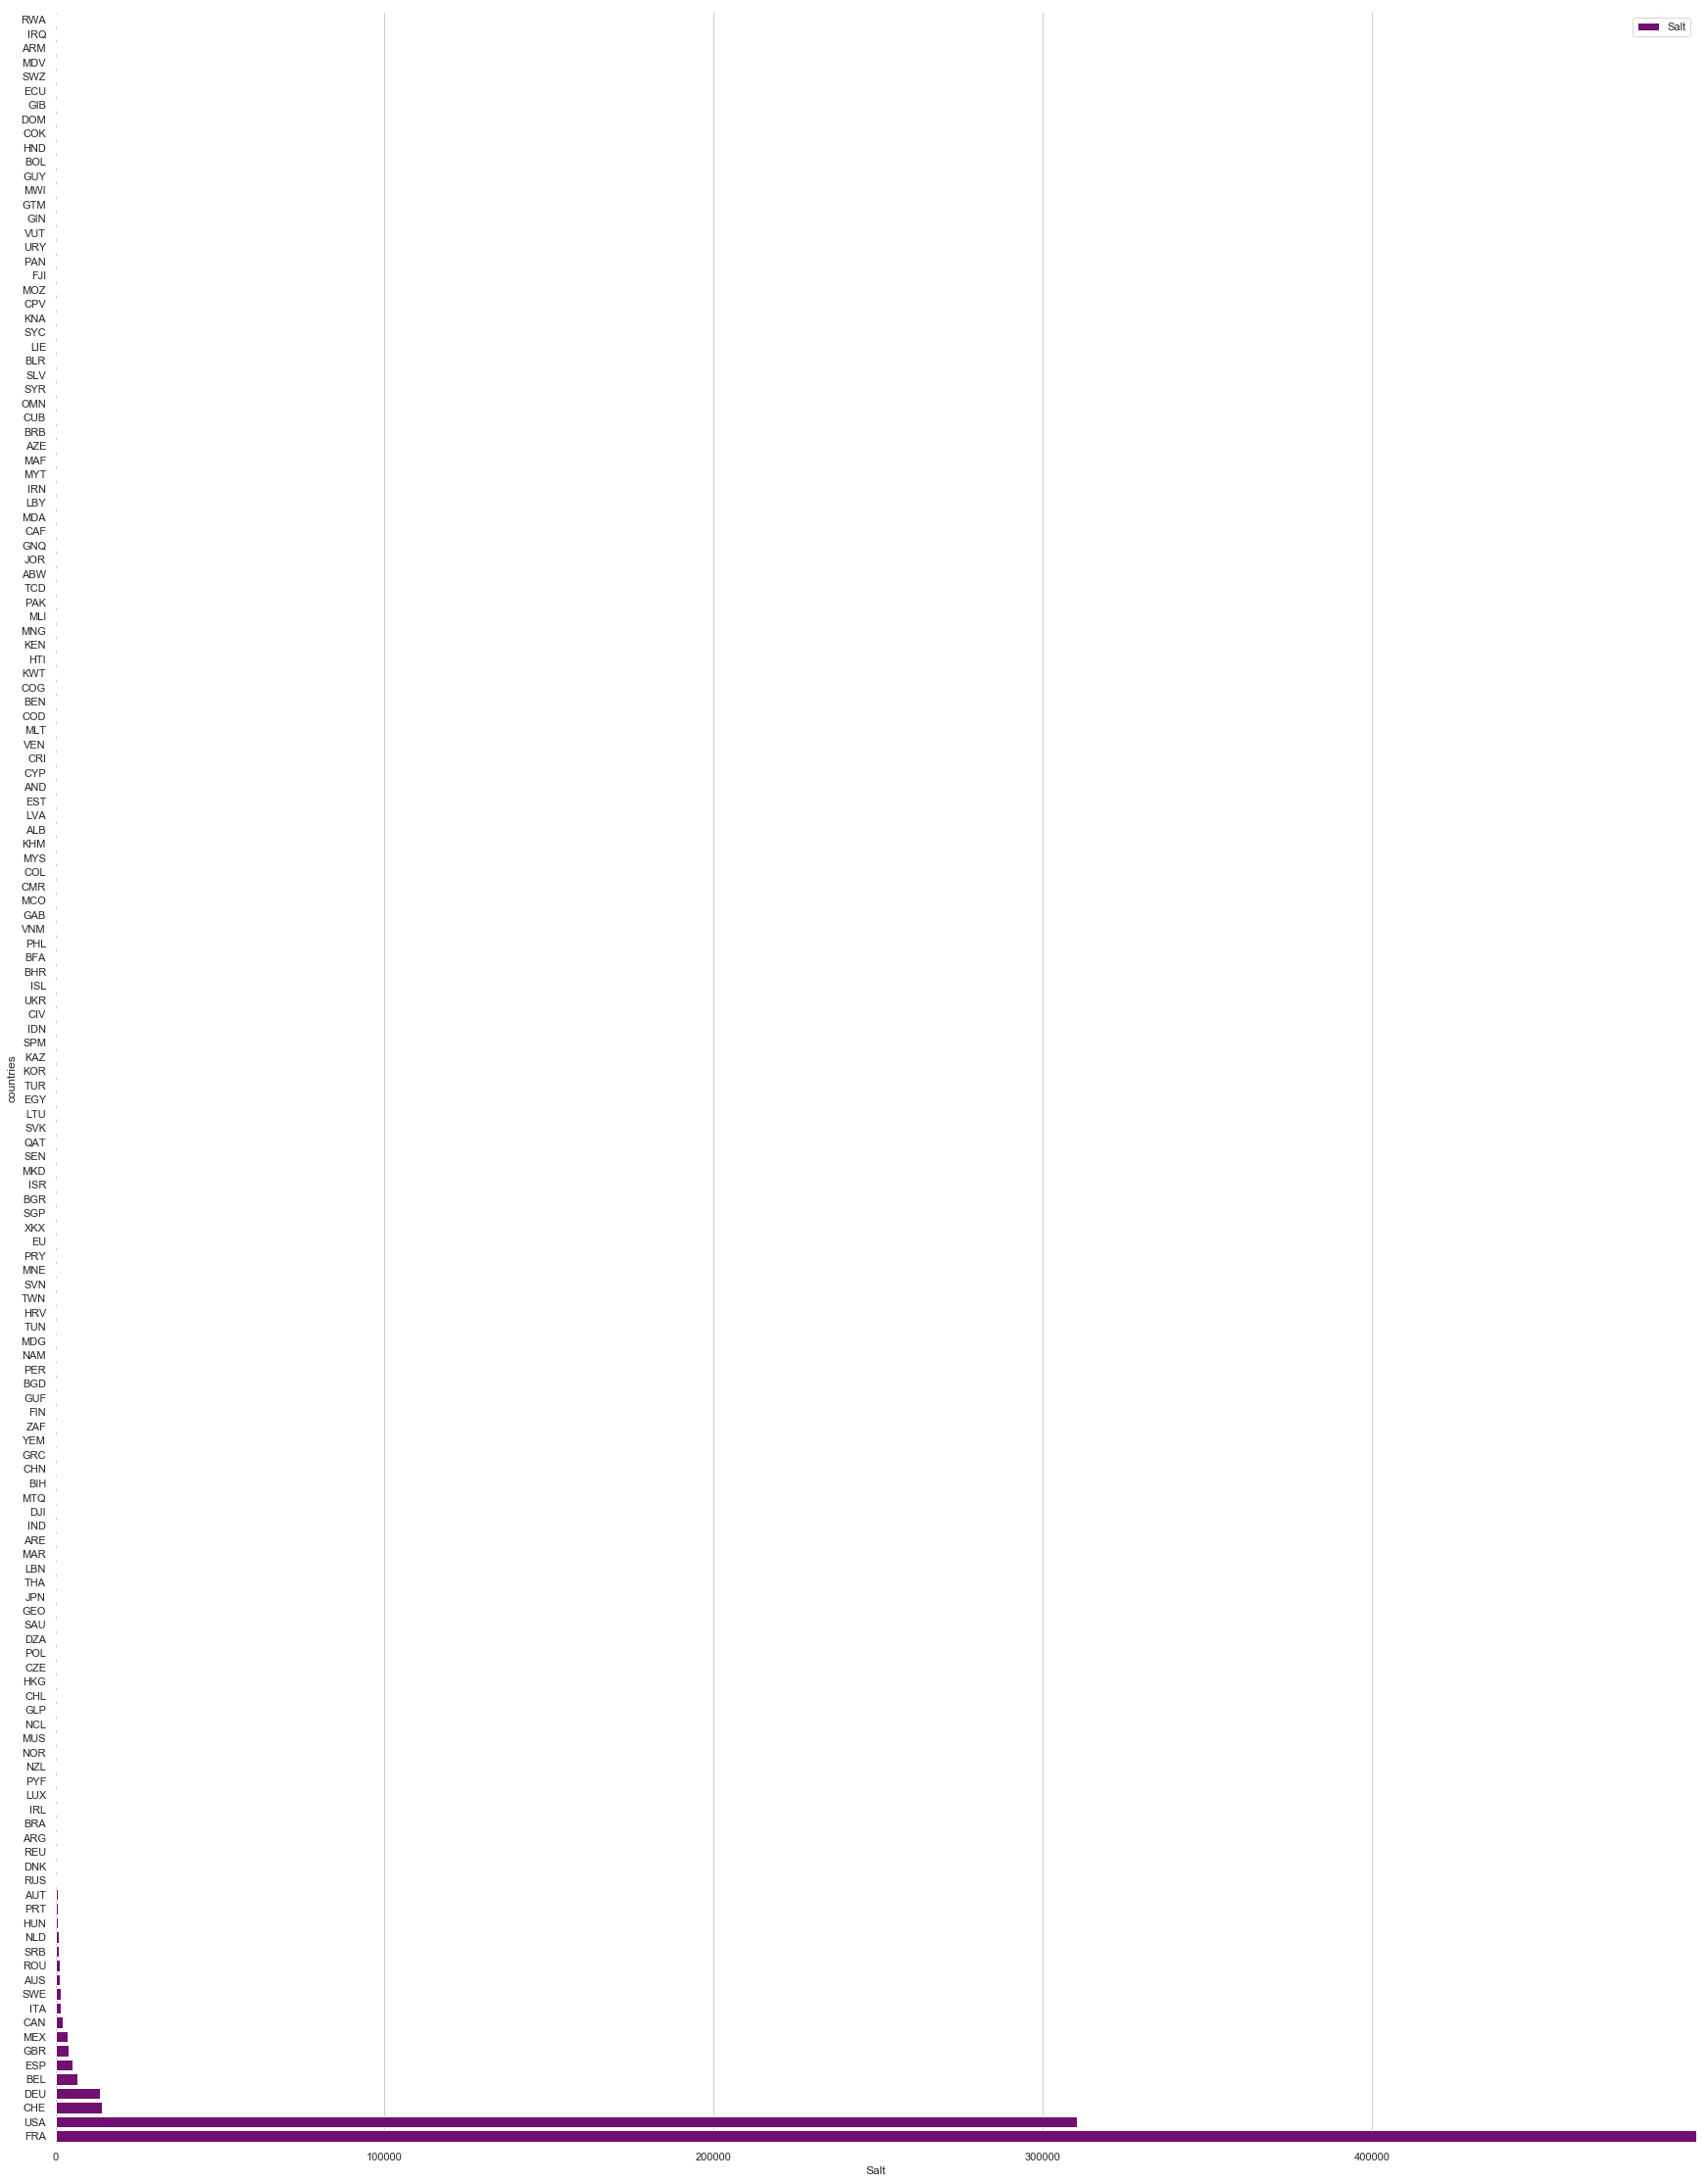

In [46]:
plot_barchar(salt, "salt_100g", "Salt", "muted", "purple", (30,40))

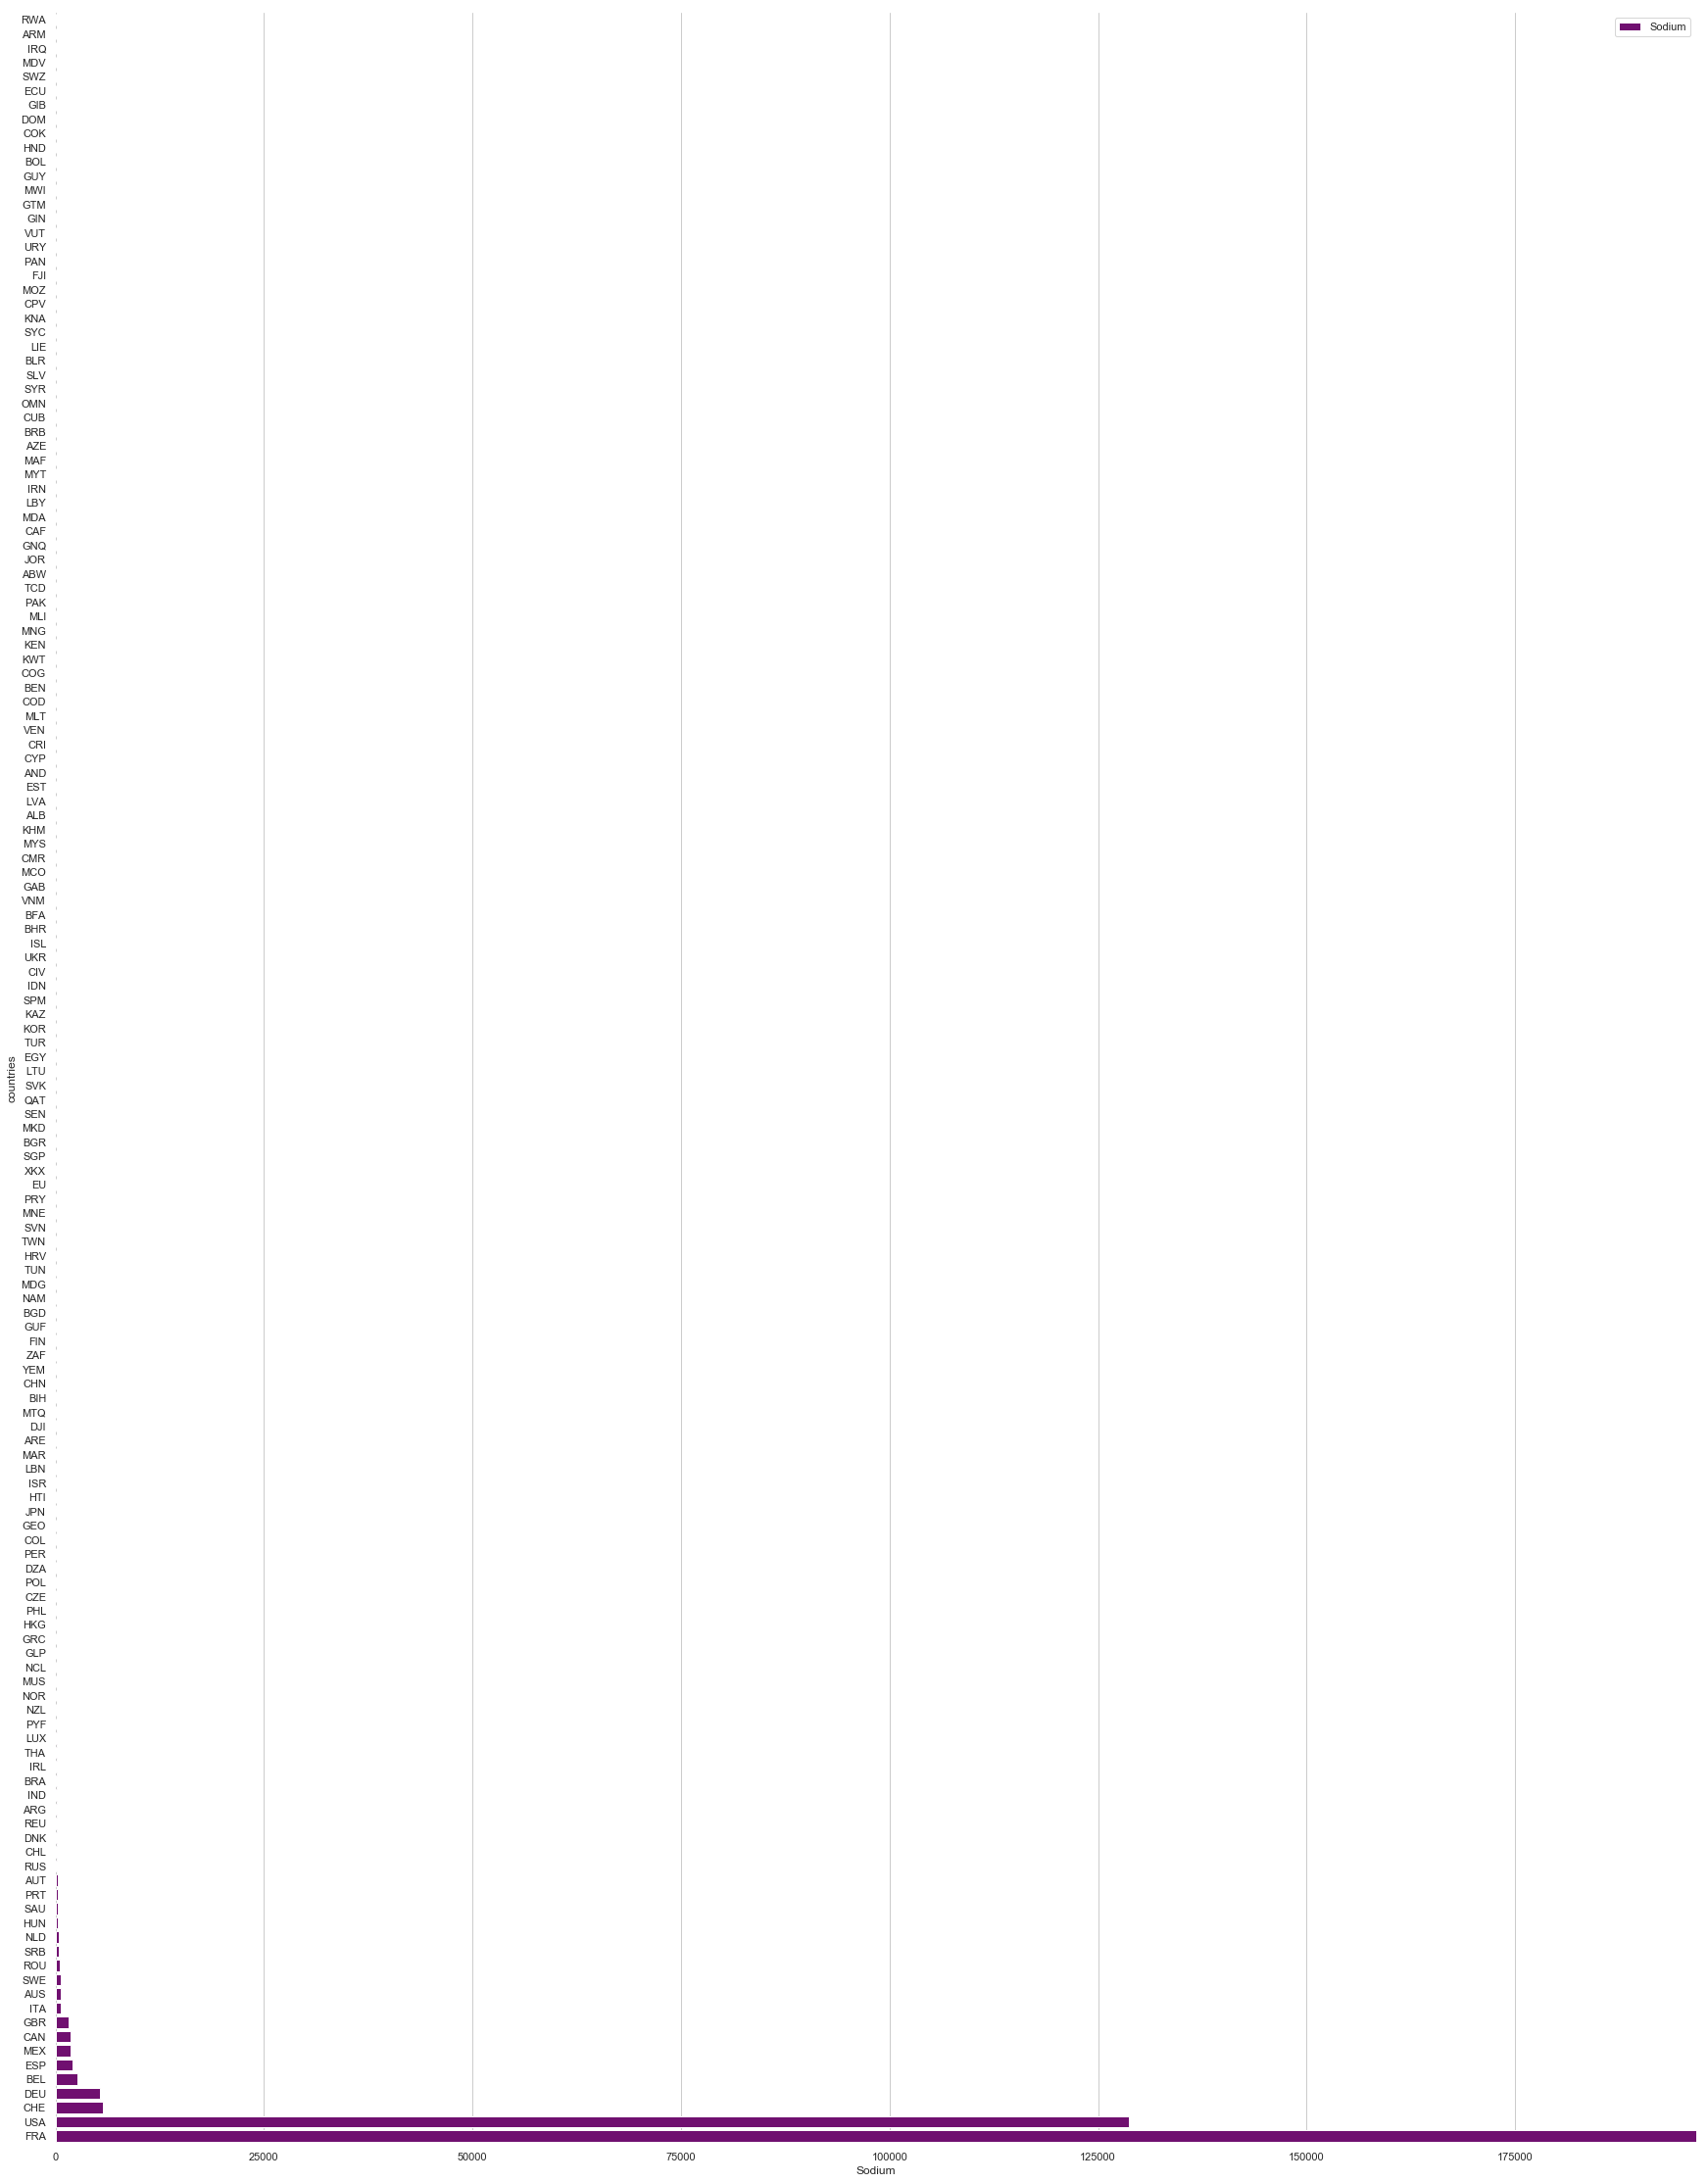

In [33]:
plot_barchar(sodium, "sodium_100g", "Sodium","pastel", "purple", (30,40))

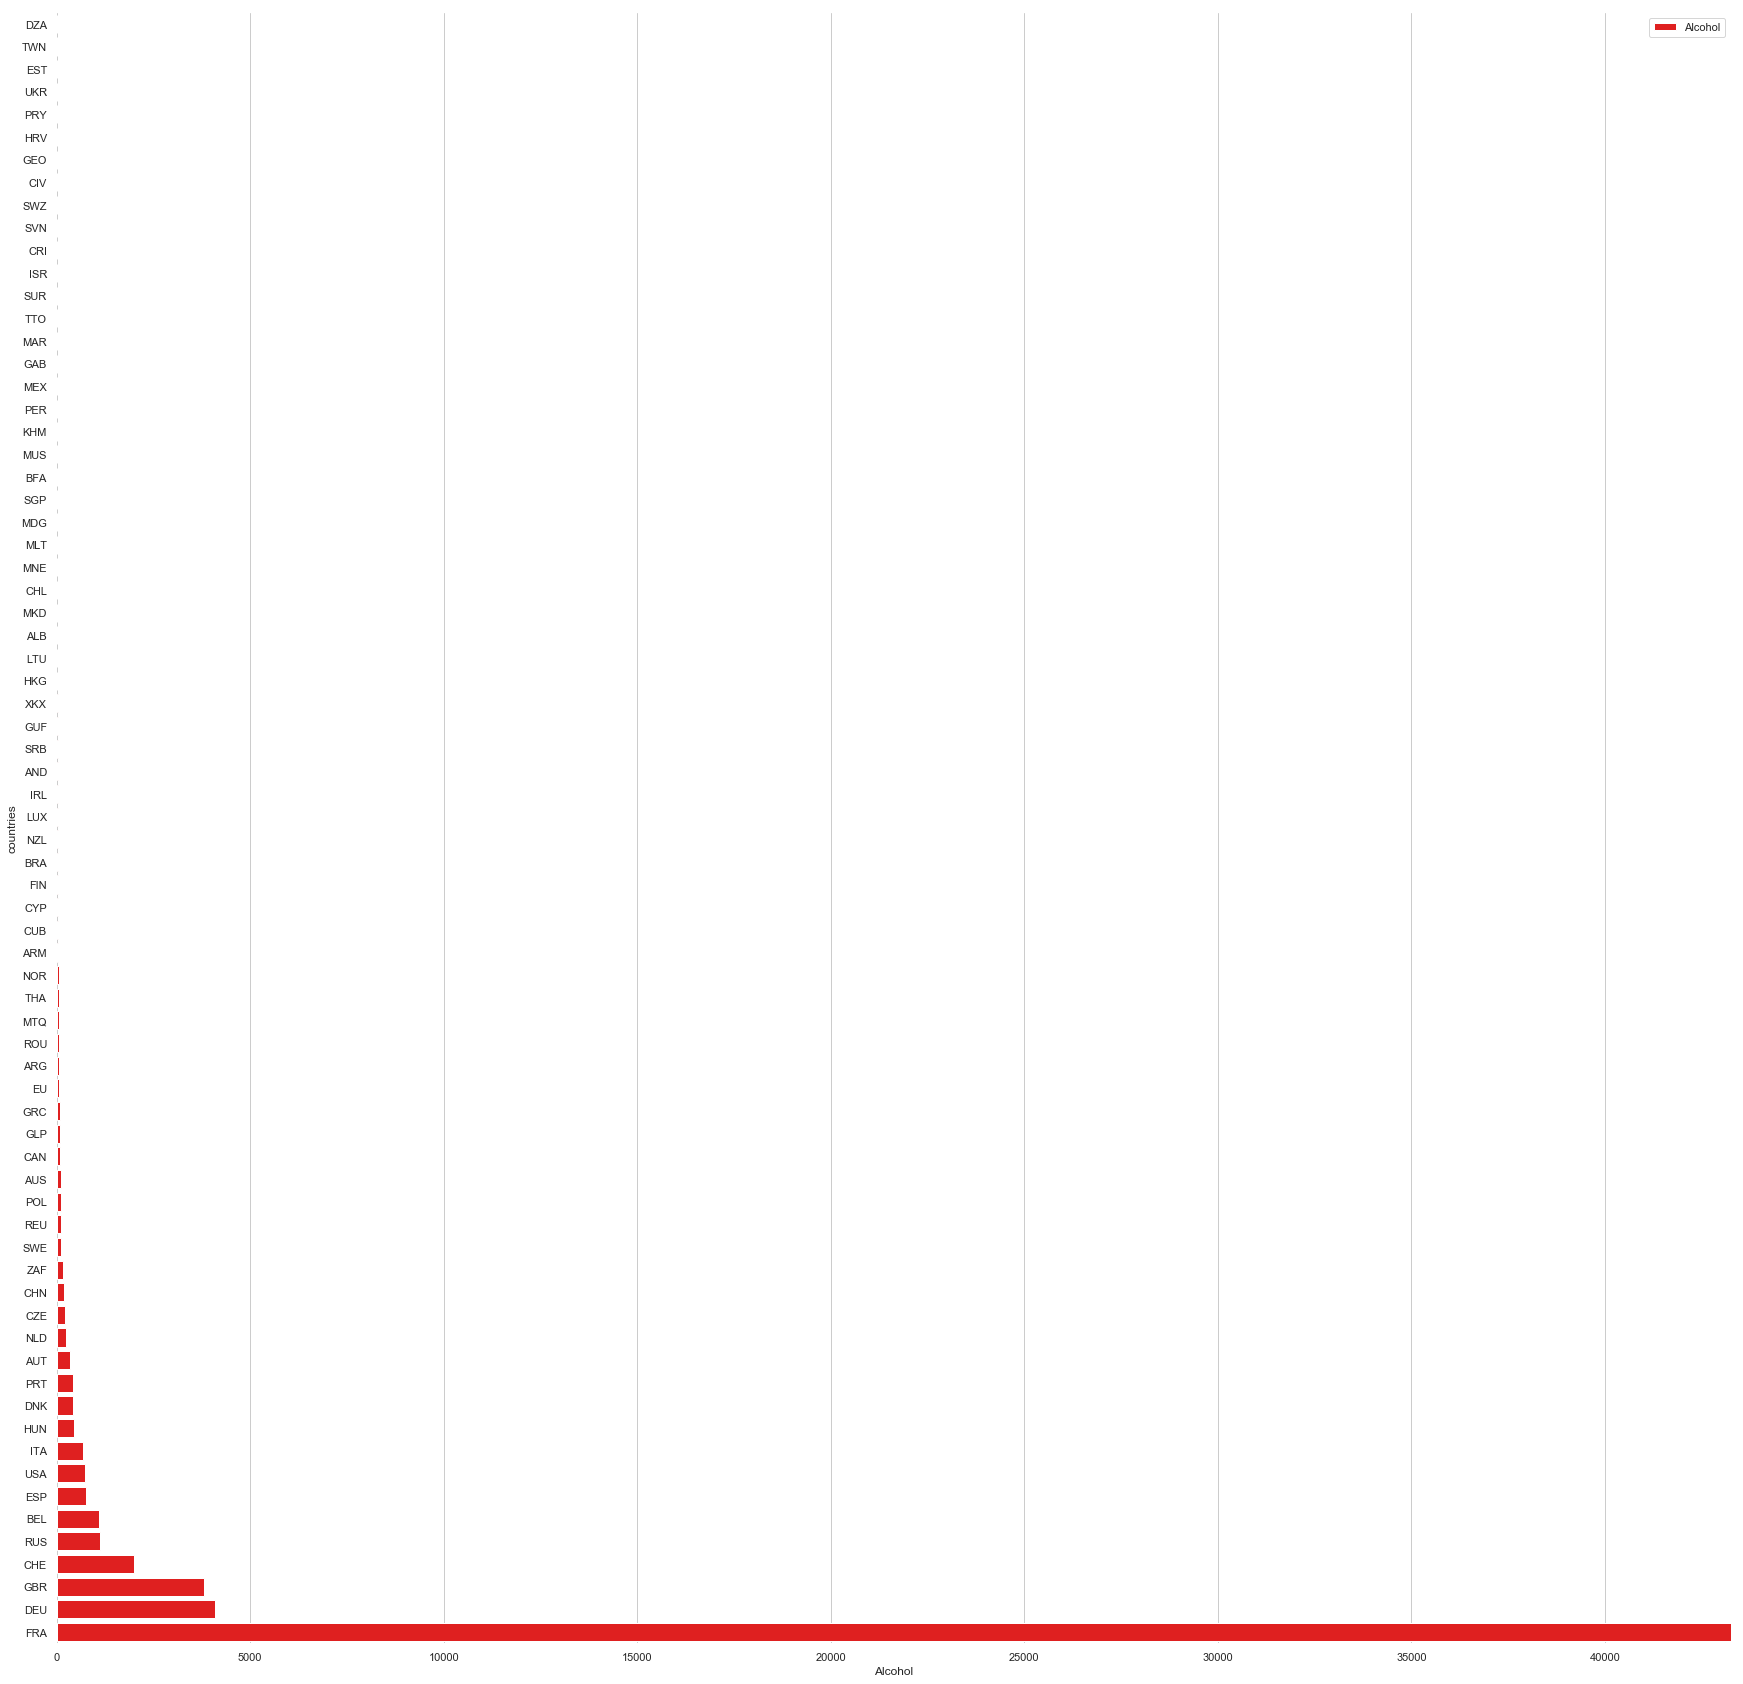

In [35]:
plot_barchar(alcohol, "alcohol_100g", "Alcohol", "muted", "red", (30,30))

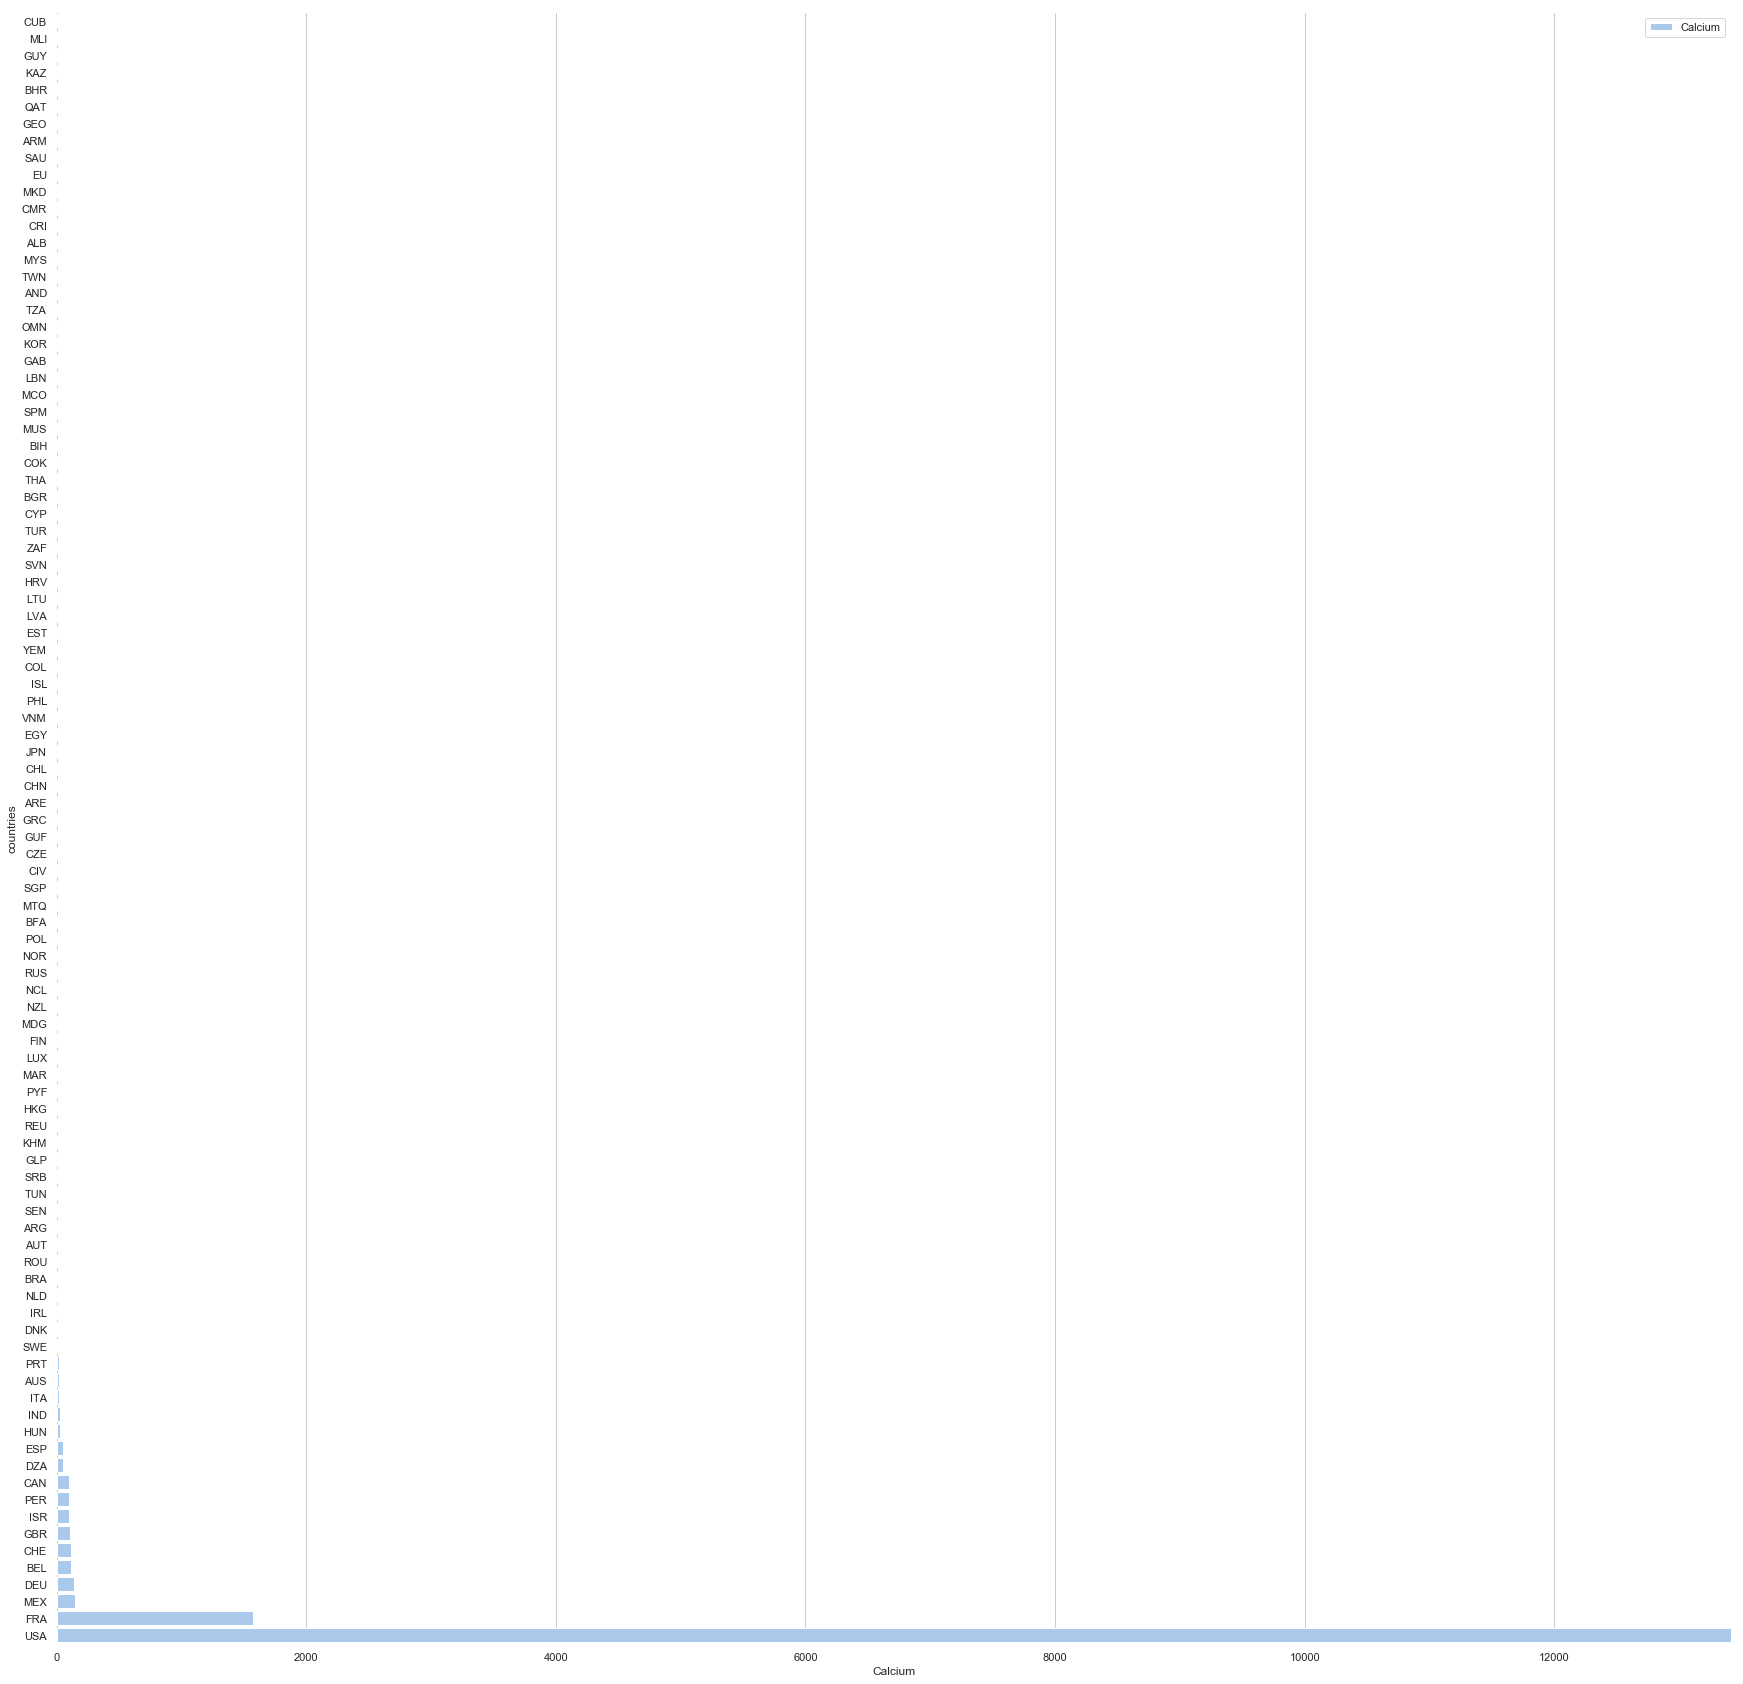

In [36]:
plot_barchar(calcium, "calcium_100g", "Calcium", "pastel", "b", (30,30))

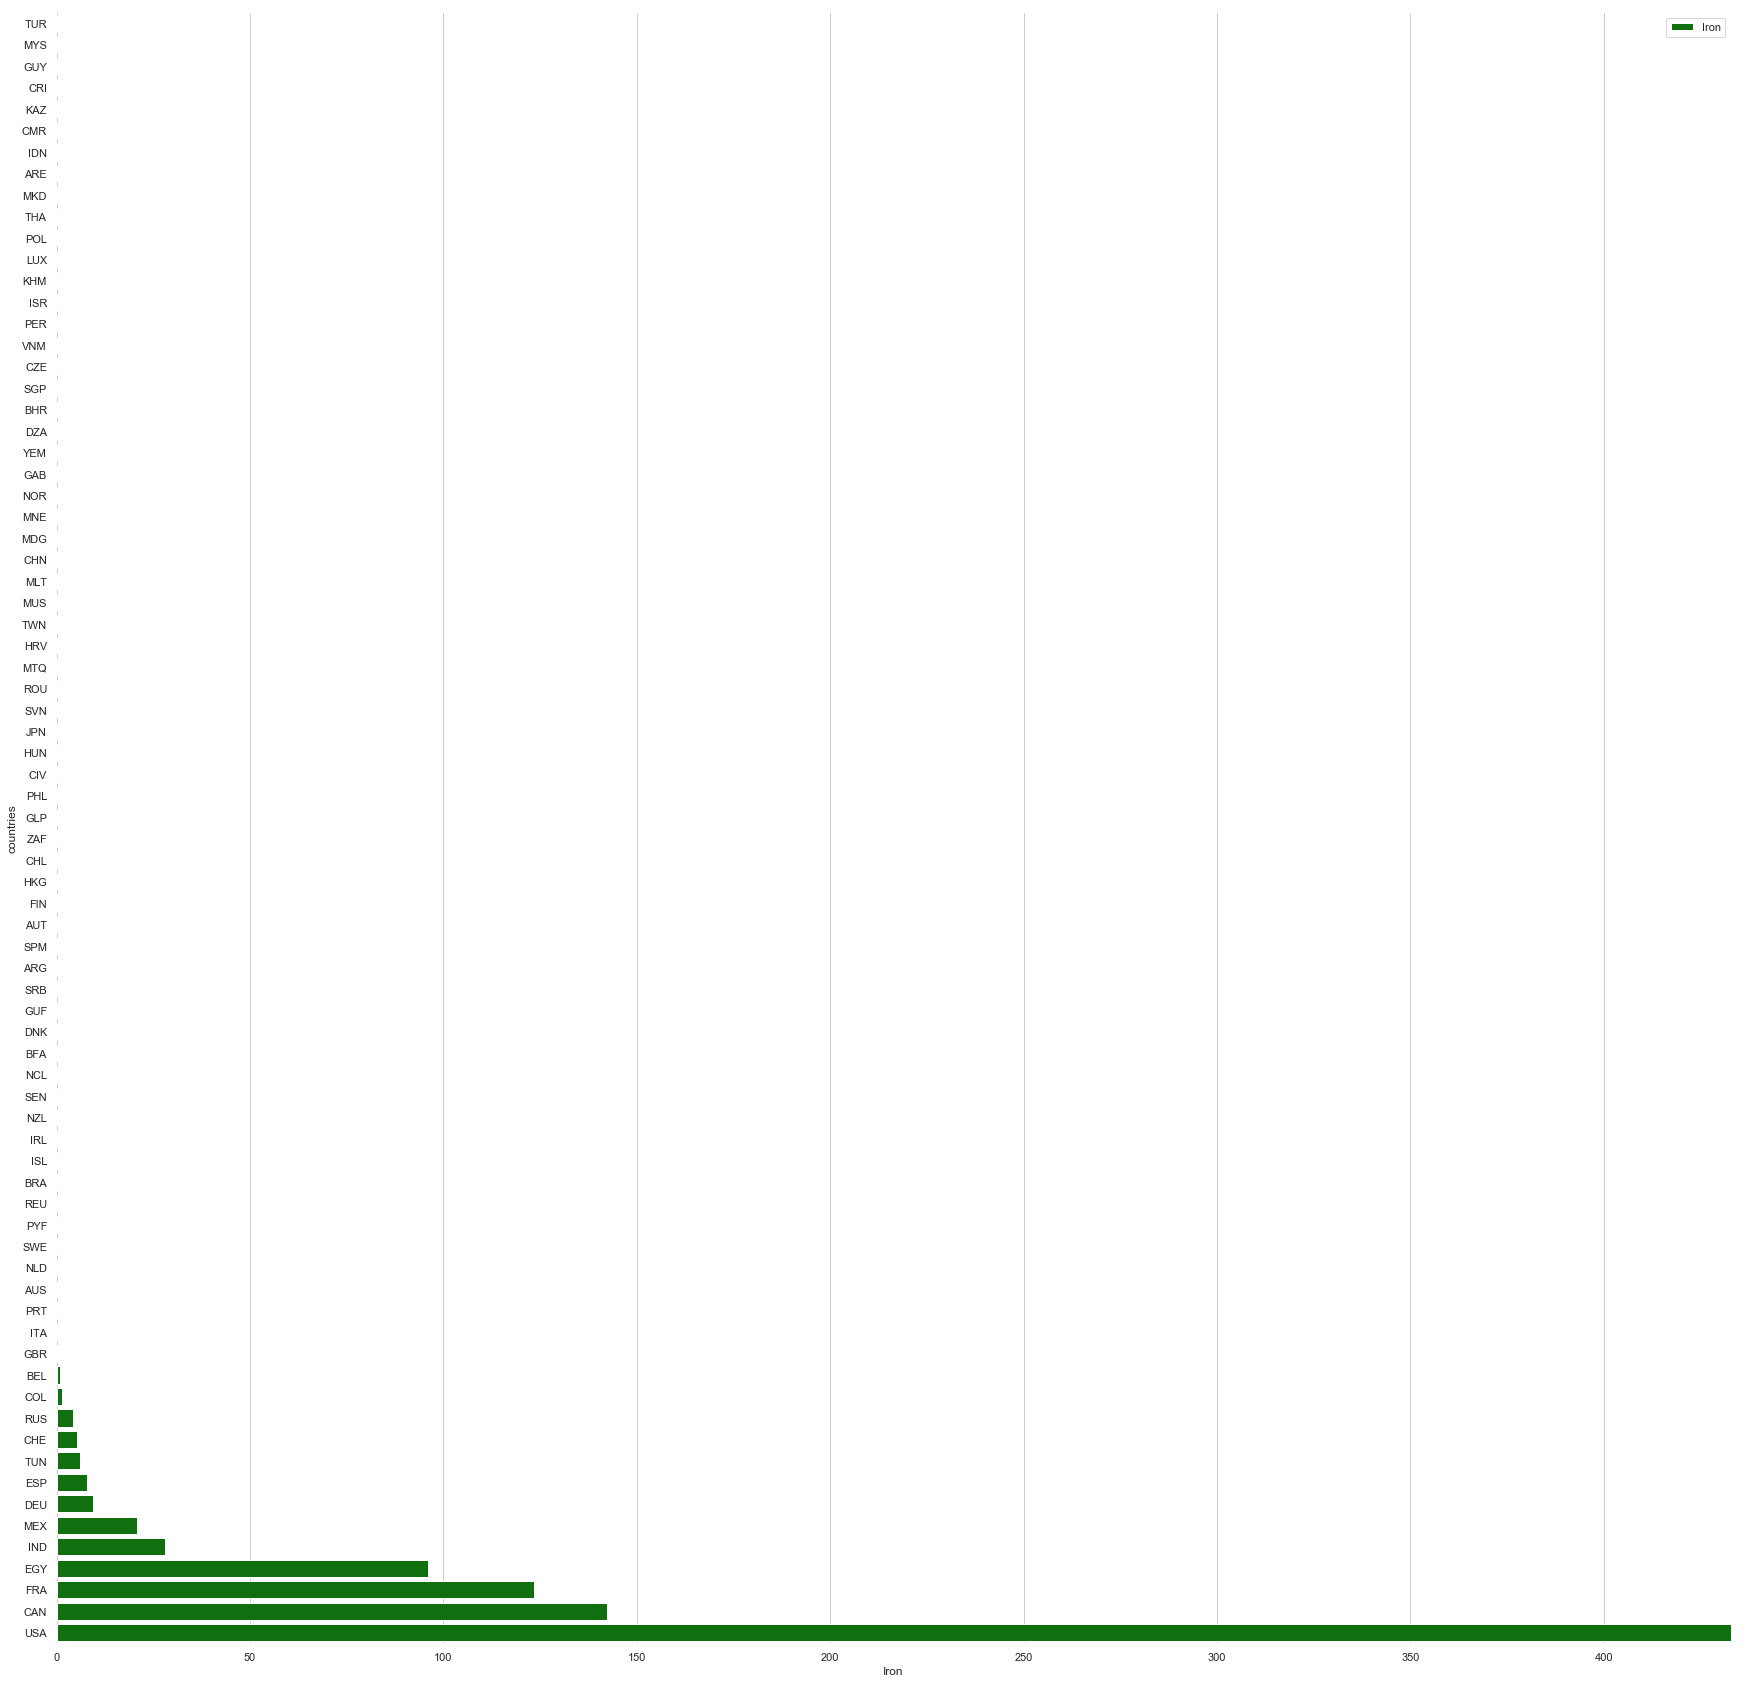

In [38]:
plot_barchar(iron, "iron_100g", "Iron", "muted", "green", (30,30))

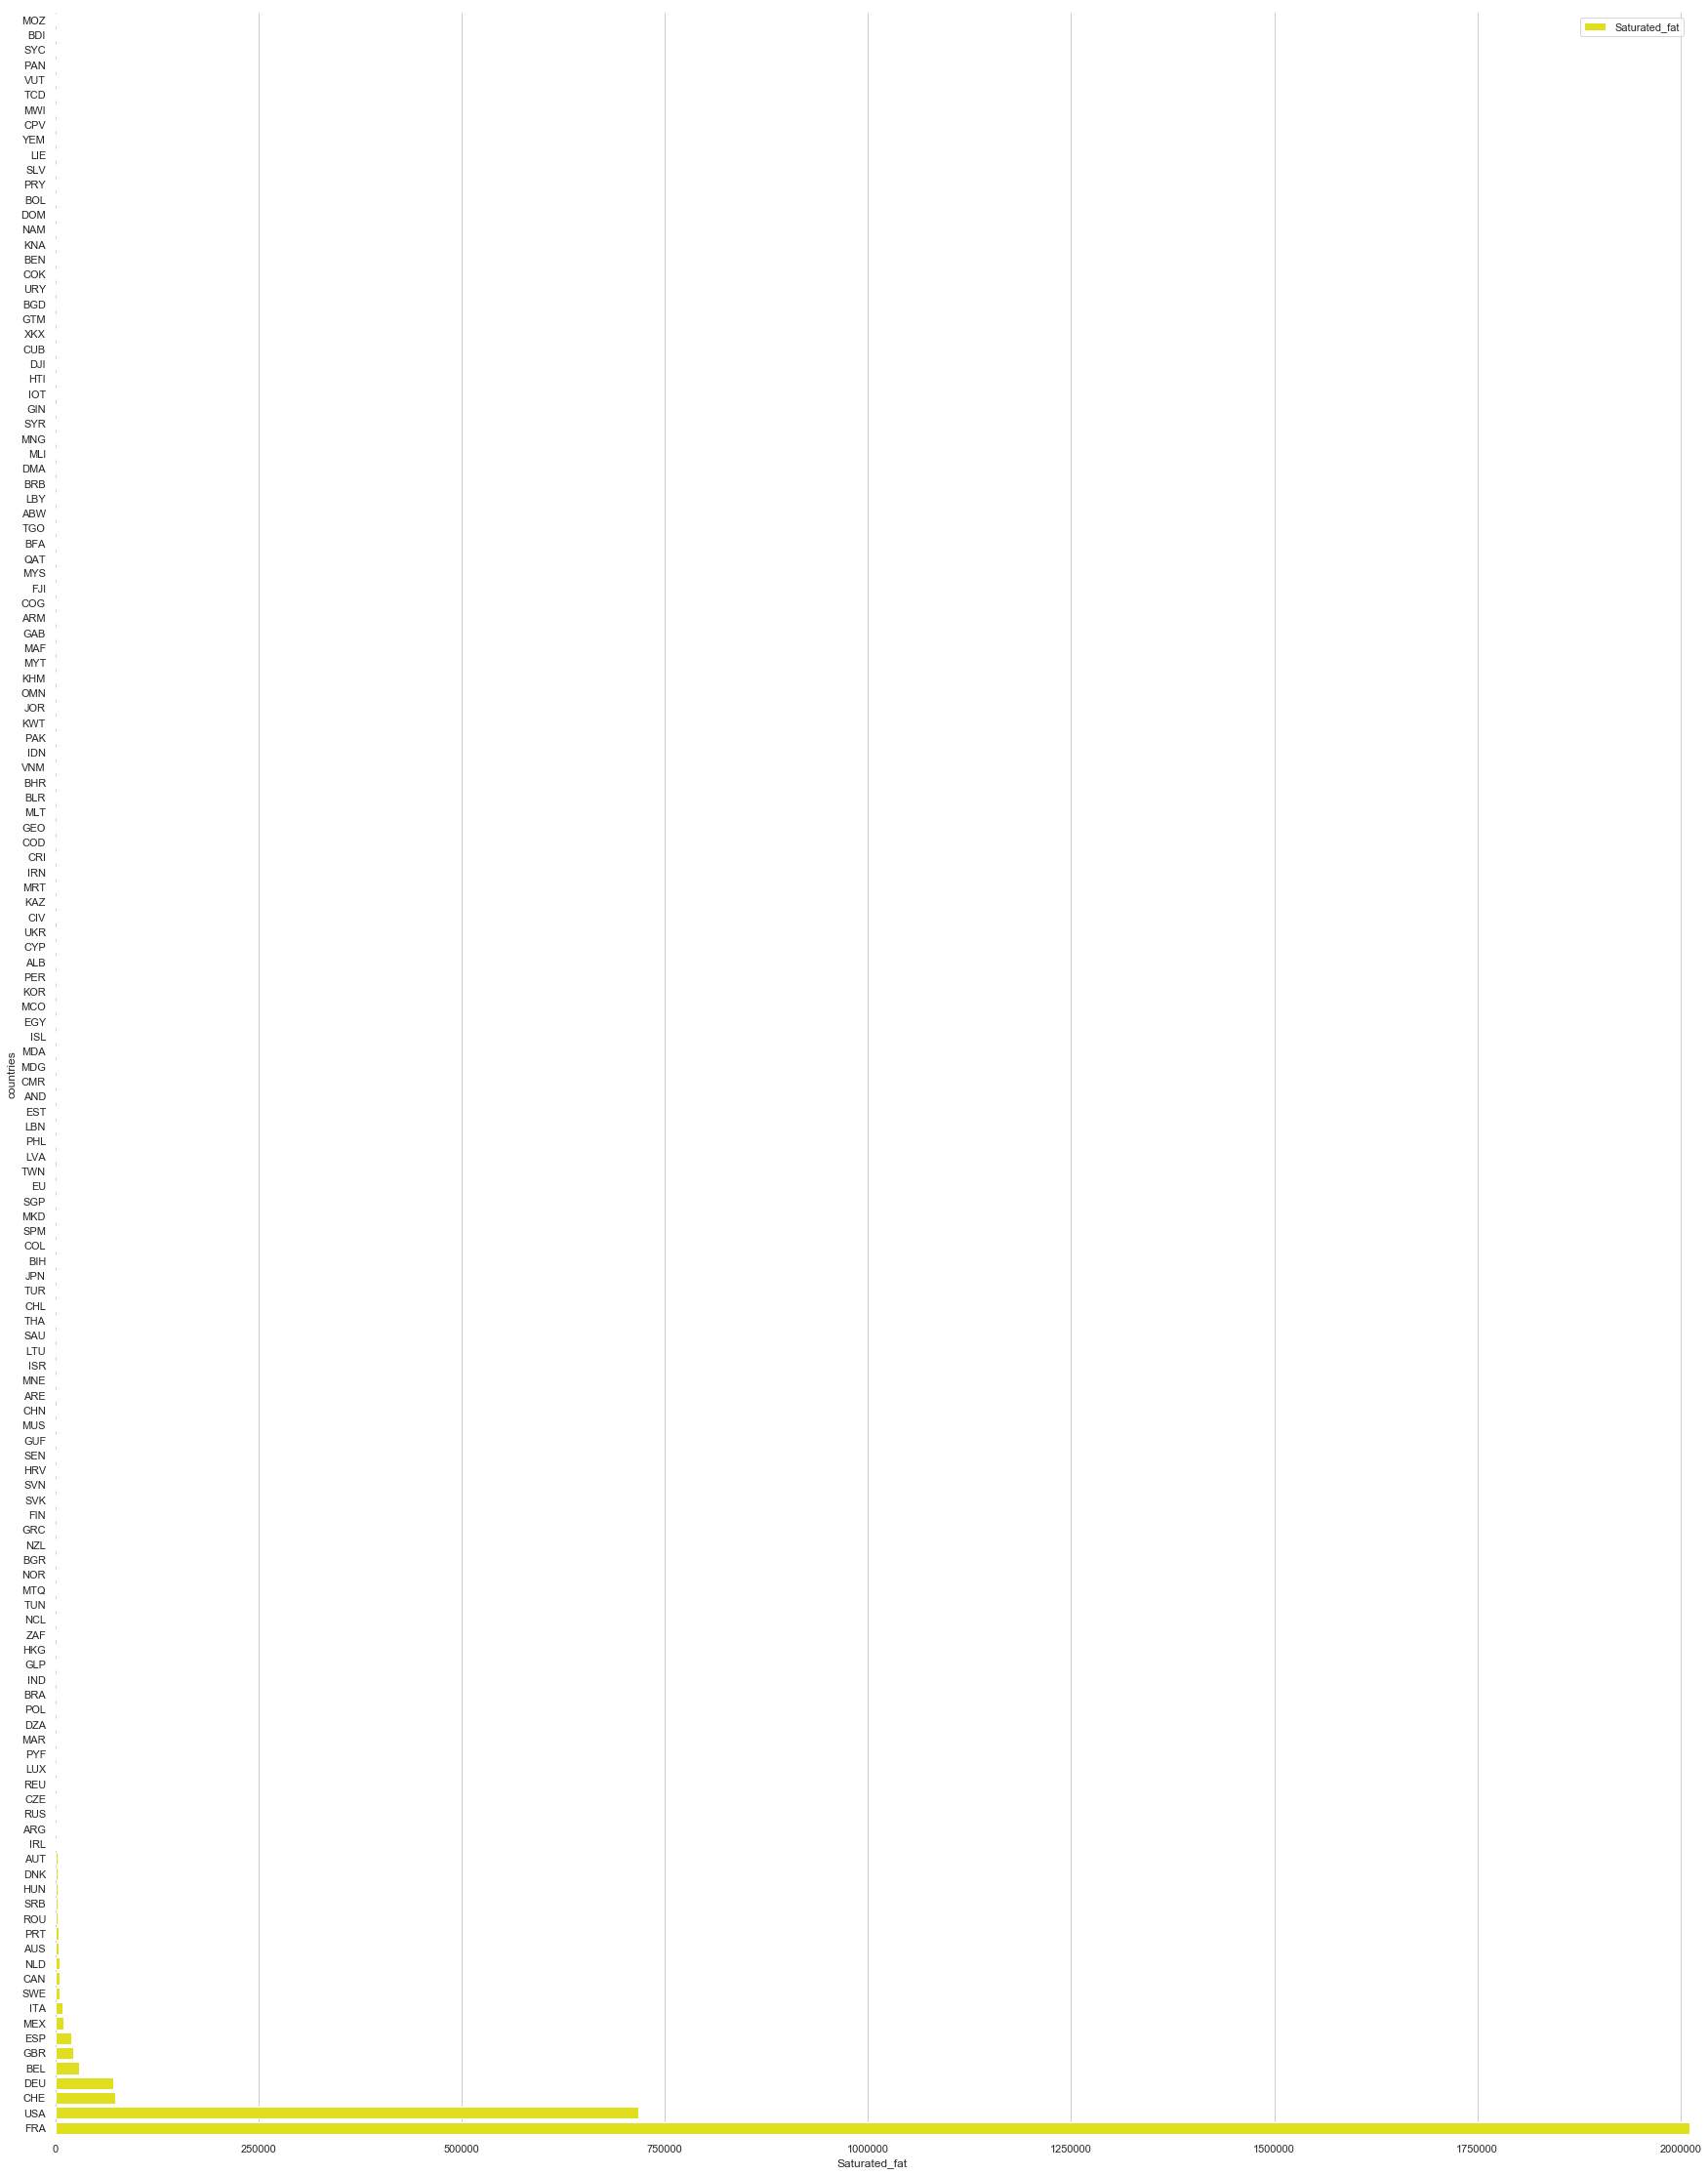

In [41]:
plot_barchar(saturated_fat, "saturated-fat_100g", "Saturated_fat", "muted", "yellow", (30,40))

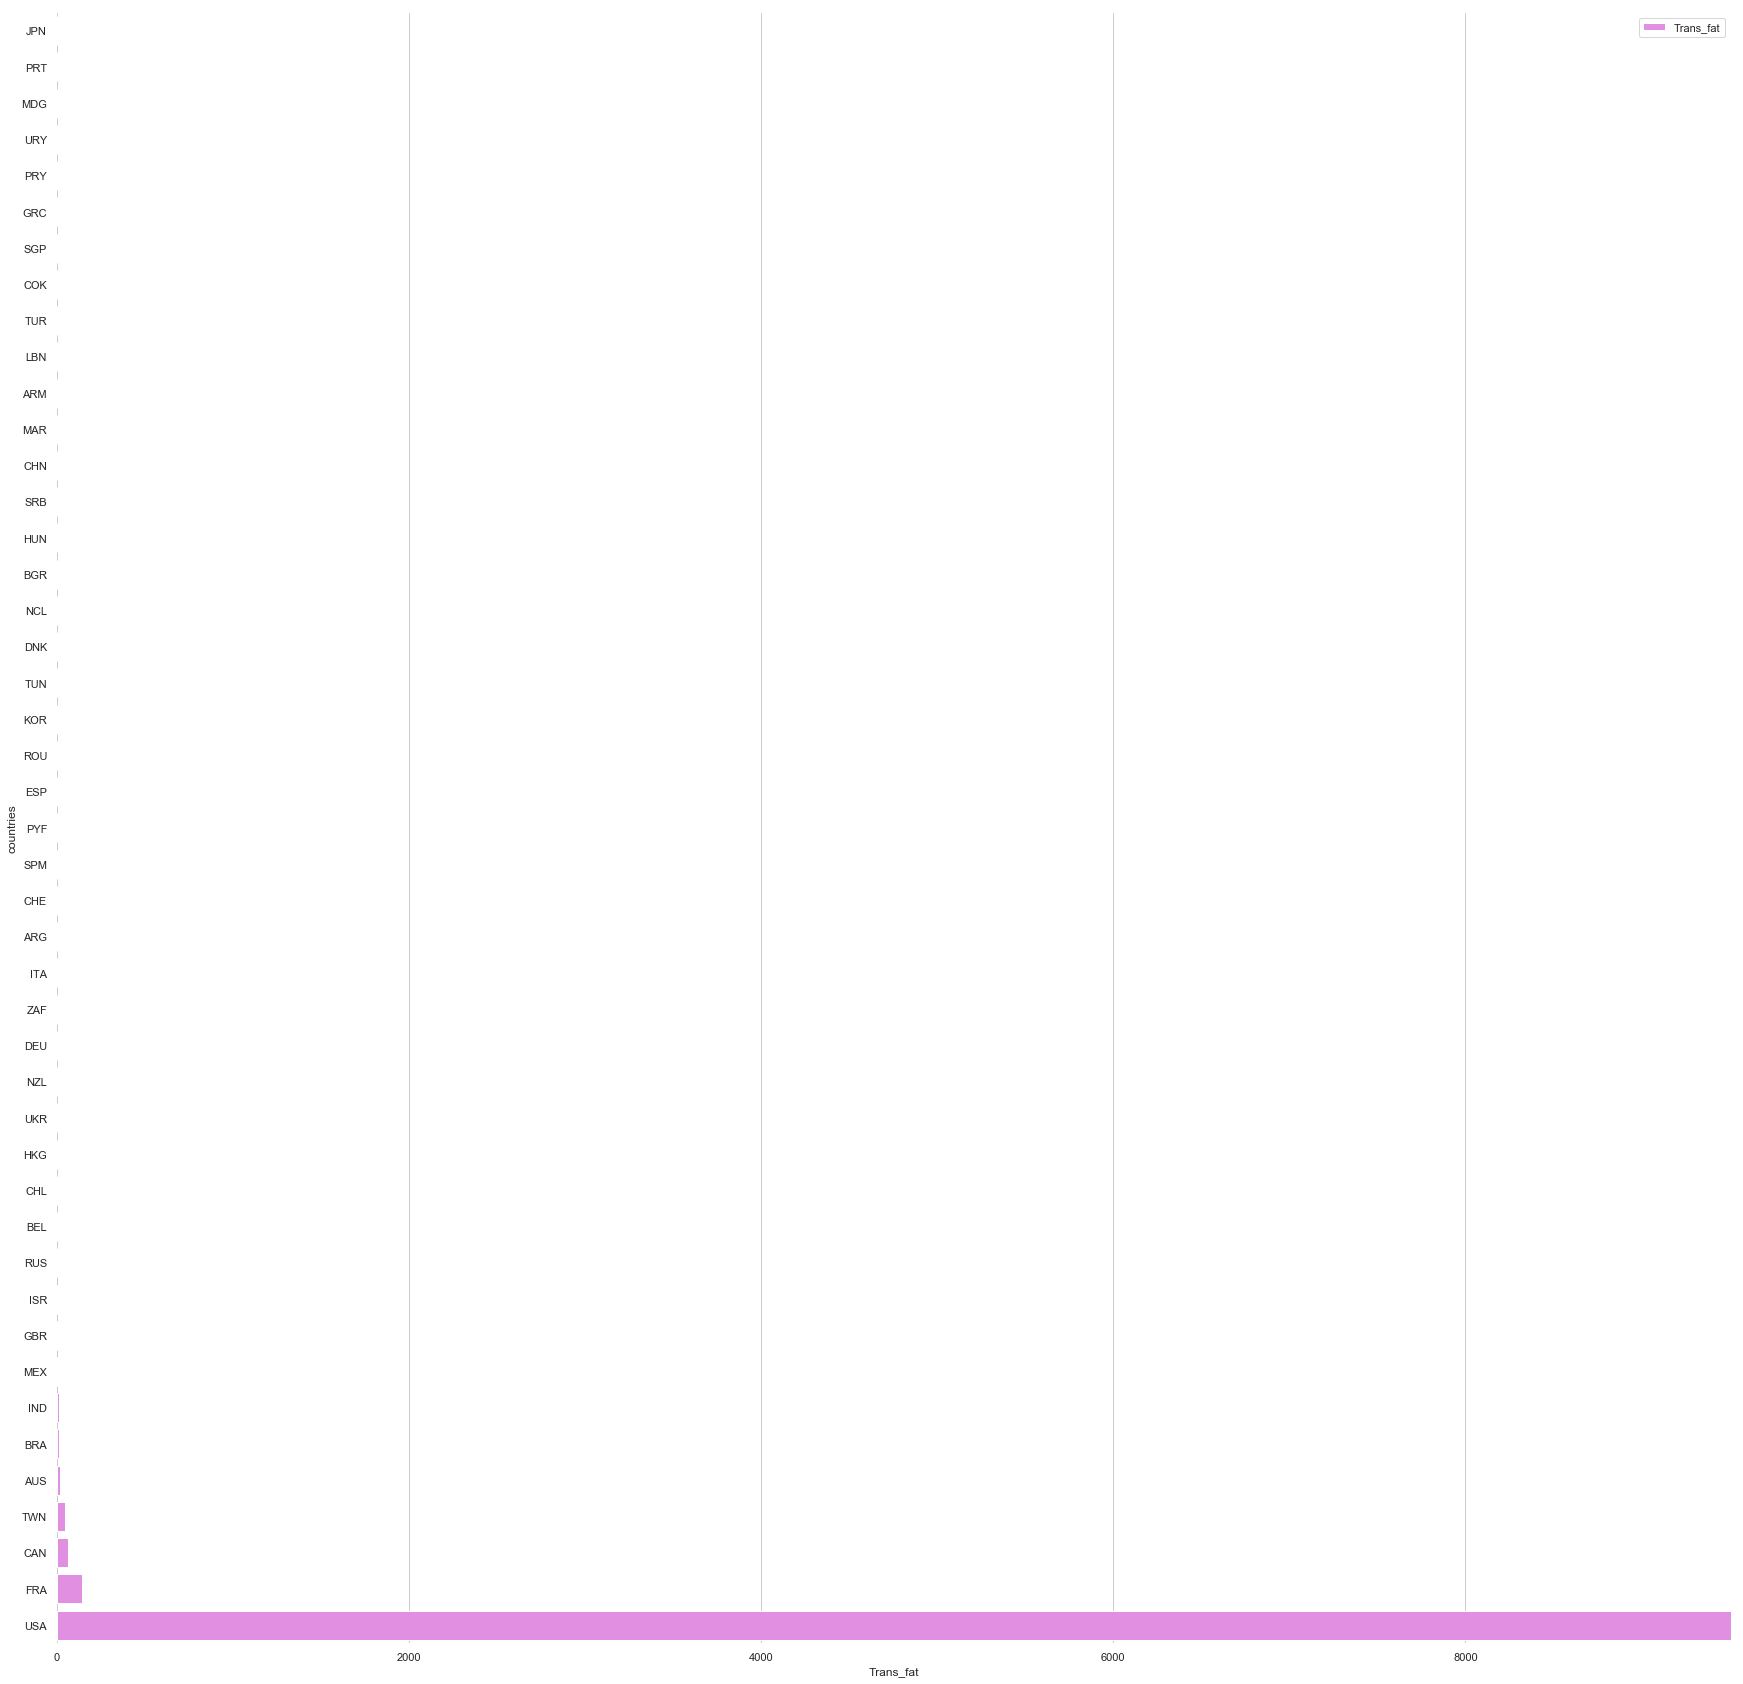

In [45]:
plot_barchar(trans_fat, "trans-fat_100g", "Trans_fat", "pastel", "violet", (30,30))

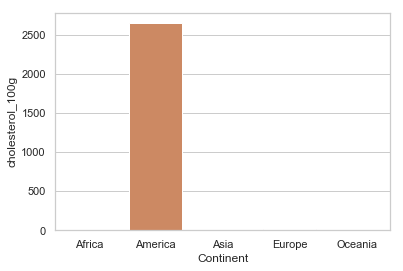

In [65]:
ax = sns.barplot(x=continents_df.index, y=continents_df["cholesterol_100g"], capsize=.2)

## Processing Data (Binary Columns) <a id="processing_data"></a> [[up](#Table-of-Contents)]
Now that our data has been translated and is in a nicer format. We will categorize our food by binary columns for each type of dietary restriction we wish to look at.

# Data Visualization & Analysis <a id="data_analysis"></a> [[up](#Table-of-Contents)]
TO BE COMPLETED FOR MILESTONE 3

In [43]:
saveTranslations()

In [1]:
# loading json file for co
country_boundaries_path = os.path.join(data_folder, country_json_file)
country_bound_data = json.load(open(country_boundaries_path))

world_map = folium.Map(
    tiles='cartodbpositron',
    zoom_start = 3
)

folium.GeoJson(country_bound_data).add_to(world_map)

world_map

NameError: name 'os' is not defined

## Maps

## Correlations b/w Neighbouring Countries <a id="correlation_neighbours"></a>

In [ ]:
desired_columns = ["cholesterol_100g",
                    "fat_100g",
                    "proteins_100g",
                    "fiber_100g",
                    "carbohydrates_100g",
                    "sugars_100g",
                    "salt_100g",
                    "sodium_100g",
                    "alcohol_100g",
                    "calcium_100g",
                    "iron_100g",
                    "saturated-fat_100g",
                    "trans-fat_100g",
                    "country_code"]
correlation_df = food_df[desired_columns]
correlation_df.head(5)

In [ ]:
asia = ['AFG', 'ARE', 'ARM', 'BGD', 'BHR', 'BRN', 'CHN','HKG', 'IDN', 'IND','IRN',
       'IRQ','ISR', 'JOR','JPN','KAZ','KGZ','KHM','KOR','KWT','LBN','LKA',
       'MDV','MMR','MNG','MUS','MWI','MYS','NPL','OMN', 'PAK','PHL',
       'QAT','SAU','SGP','SYR','THA','TJK','TLS','TUR','TWN','VNM', 'YEM']

europe = ['AIA','ABW', 'ALA', 'ALB', 'AND', 'AUT', 'AZE', 'BEL', 'BGR', 'BIH', 'BLR', 
          'CHE', 'CYP', 'CZE','DEU','DNK','ESP','EST','EU','FIN','FRA',
         'GBR','GEO','GIB','GLP','GRC','HND','HRV','HUN', 'IMN','IOT',
         'IRL','ISL','ITA','LIE','LTU','LUX','LVA','MCO','MDA','MKD','MLT',
         'MNE','MSR','MTQ','MYT','NLD','NOR','POL','PRT','PYF','REU','ROU',
         'RUS','SRB','SVK','SVN','SWE','UKR','VEN', 'XKX']

america = ['ARG', 'ATG', 'BOL', 'BRA', 'BRB', 'CAN', 'CHL', 'COL', 'CRI', 'CUB',
          'DMA', 'DOM', 'ECU','GTM','GUF','GUY','HTI','JAM','KNA','LCA','MAF',
          'MEX','NIC','PAN','PER','PRI','PRY','SLV','SPM','SUR','TTO','URY','USA']

africa = ['AGO','BDI','BEN', 'BFA', 'CAF', 'CIV', 'CMR', 'COD','COG','CPV','DJI',
          'DZA','EGY','ETH','GAB','GHA','GIN','GNQ','KEN','LBY','MAR','MDG','MLI',
          'MOZ','MRT','NAM','NER','NGA','RWA','SEN','SLE','SOM','SWZ','SYC',
          'TCD','TGO','TUN','TZA','ZAF']

oceania = ['AUS', 'COK', 'FJI','NCL','NZL','VUT','WLF']

In [ ]:
def GetContinent(country):
    if country in asia:
        return "Asia"
    elif country in europe:
        return "Europe"
    elif country in america:
        return "America"
    elif country in africa:
        return "Africa"
    else:
        return "Oceania"

In [ ]:
correlation_df['Continent'] = correlation_df['country_code'].apply(lambda x: GetContinent(x))

In [15]:
continents_df = correlation_df.groupby(correlation_df['Continent']).sum()
continents_df.head()

,cholesterol_100g,fat_100g,proteins_100g,fiber_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,alcohol_100g,calcium_100g,iron_100g,saturated-fat_100g,trans-fat_100g
Continent,,,,,,,,,,,,,
Africa,0.368456,1.189971e+04,5.025045e+03,1094.667000,2.788392e+04,1.192522e+04,704.946753,277.538045,202.290,70.077083,102.176990,4.232851e+03,2.92560
America,2644.234264,2.182648e+06,1.201411e+06,420084.048912,5.943126e+06,2.818083e+06,317453.945393,133125.873664,1045.779,13767.102421,597.454082,7.358706e+05,9599.36218
Asia,1.228020,1.185701e+04,6.154729e+03,1343.487049,3.269679e+04,1.353373e+04,1661.329107,1157.552401,354.940,139.932034,28.164882,4.346569e+03,73.09040
Europe,18.736218,5.900199e+06,3.612682e+06,421630.218960,1.195858e+07,6.047837e+06,554465.821215,219022.250935,59997.506,2228.581860,152.877637,2.278717e+06,174.24700
Oceania,0.318670,1.539999e+04,8.263073e+03,1884.440004,3.552657e+04,1.870184e+04,1801.474817,827.116438,178.800,31.217820,0.308999,6.044348e+03,23.35910


In [ ]:
correlation_df[['country_code','Continent']].head(5)

In [ ]:
ax = sns.heatmap(continents_df, cmap="Blues")
plt.yticks(rotation=0) 

In [ ]:
countries_df = correlation_df.groupby(correlation_df['country_code']).sum()
countries_df.head()